# Case Study Unit 6: Real Time Location System

Juhee Dalal

MSDS 7333: Quantifying the World, 2/23/17

## INTRODUCTION

The focus of this study is to explore Indoor positioning systems (IPS) and local area networks because Global positioning systems (GPS) do not function well inside buildings. Building an indoor positioning system requires training and testing data. The training data will be the reference set where the signal strength is measured from a mobile/scanning device to a fixed access point or a router. The locations of the routers are known. The training data is then used to build a model that predicts the location of unknown mobile devices based on the detected signal strengths. 

This study was initiated by researchers at the University of Mannheim and explained in detail in Data Science in R: A Case Study Approach to Computational Reasoning and Problem Solving by Nolan and Lang. In this report, we will continue upon their research and test different scenarios by including and excluding data for specific routers. We will then use k-Nearest Neighbors to determine which model is the most efficient.

k-Nearest Neighbors will be used to determine the unknown locations and potential issues with the data set we choose. The floor plan in the study from Nolan and Lang shows six access points. The original data set contains seven access points (each have a unique MAC address). The researchers decided to keep the access point with MAC address 00:0f:a3:39:e1:c0 and remove 00:0f:a3:39:dd:cd, along with its corresponding data. In this study, we will explore different combinations of the data to determine which MAC address will yield the best location prediction. We will first decide which of the two MAC addresses mentioned should be used for the Real-Time Location System, or if we should use both of them simultaneously. 

The second approach we will explore uses weights on the received signal strength. The weight is inversely proportional to the distance (signal strength) from the test observation. This will allow for the points that are closer to the access point to have a greater weightage on the k-Nearest Neighbor calculation of location than the points that have a weaker signal strength. We will then determine which range of weight values will give better prediction values than for the unweighted k-Nearest Neighbor approach mentioned earlier. 

### Data Set Description

There are two different data sets - offline and online. We will be working with the offline data for the first portion then the online data will be used for the k-Nearest Neighbors in conjunction with the offline data. The offline data is our reference/training set, while the online data is our testing set and will be used for location prediction of the unknowns.

The data set consists of 4 main components: the ID, position, degree and MAC address. The variable t is the timestamp of the data being collected - in milliseconds since 12:00 AM 1/1/1970 UTC. The id variable is the MAC address of the scanning device. The pos variable indicates the coordinates of the scanning device in the building. The rest of the data contains the MAC address of the access point/adhoc devices and the corresponding signal strength (in dBm) to the scanning device, along with the channel frequency and mode of operation. The mode of operation may be 3 or 1 (3 for fixed access point or 1 for adhoc mode).

## METHODS

We begin by importing and cleaning the offline data set. Then, we will run some exploratory analysis to get a better understanding of the data.

## Importing and Cleaning the Data

First, we are reading in the offline data text file and counting the number of comments in the data file. This is important because the "#" is the comment character in R, and any lines with this character at the beginning should not be read into R as data. Then, we're determining the number of lines in the file using the length function. The difference between the number of lines and the number of comments is the number of observations in the data.  

In [1]:
options(digits = 2)
txt = readLines("offline.final.trace.txt")

In [2]:
sum(substr(txt, 1, 1) == "#")
length(txt)

[1] 5312

[1] 151392

Each handheld device has a time stamp (t), a MAC address (id), coordinates of the scanning device (pos), and the orientation of the device(degree). The handheld also has a list of MAC addresses of a responding peer and their information. This information includes the MAC address, signal strength, channel, and device type (access point or adhoc mode). We see a sample of this in the code block below.

The data is not in a data frame format yet. The data elements are split by semi-colons, and further splits are separated by commas or equal signs. The strsplit function splits the data. Not all of the data is read in. We are first trying to understand the structure of the data by reading in the first few observations. Note that signal strenghts are given as a base 2 log, which is why some of the values are negative.

In [3]:
tokens = strsplit(txt[4], "[;=,]")[[1]]
tokens[1:10]
tokens[c(2, 4, 6:8, 10)]
tokens[ - ( 1:10 ) ]

[1] "t"                 "1139643118358"     "id"               
 [4] "00:02:2D:21:0F:33" "pos"               "0.0"              
 [7] "0.0"               "0.0"               "degree"           
[10] "0.0"

[1] "1139643118358"     "00:02:2D:21:0F:33" "0.0"              
[4] "0.0"               "0.0"               "0.0"

[1] "00:14:bf:b1:97:8a" "-38"               "2437000000"       
 [4] "3"                 "00:14:bf:b1:97:90" "-56"              
 [7] "2427000000"        "3"                 "00:0f:a3:39:e1:c0"
[10] "-53"               "2462000000"        "3"                
[13] "00:14:bf:b1:97:8d" "-65"               "2442000000"       
[16] "3"                 "00:14:bf:b1:97:81" "-65"              
[19] "2422000000"        "3"                 "00:14:bf:3b:c7:c6"
[22] "-66"               "2432000000"        "3"                
[25] "00:0f:a3:39:dd:cd" "-75"               "2412000000"       
[28] "3"                 "00:0f:a3:39:e0:4b" "-78"              
[31] "2462000000"        "3"                 "00:0f:a3:39:e2:10"
[34] "-87"               "2437000000"        "3"                
[37] "02:64:fb:68:52:e6" "-88"               "2447000000"       
[40] "1"                 "02:00:42:55:31:00" "-84"              
[43] "2457000000"        "1"

There are 11 rows in the matrix, one each for the MAC addresses and 10 columns of 6.

In [4]:
tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
mat = cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, byrow = TRUE), tmp)

dim(mat)

[1] 11 10

The processLine function repeats the above operations for each row in the text file. Each line will be split and add the MAC addresses to the matrix.

In [5]:
processLine =
function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  tmp = matrix(tokens[ - (1:10) ], ncol = 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp),
               ncol = 6, byrow = TRUE), tmp)
}

Now, we are testing the function on several lines to make sure it works. Sapply gives the number of records per row. The individual matrices are then put into a single data frame.

In [6]:
 tmp = lapply(txt[4:20], processLine)
sapply(tmp, nrow)

[1] 11 10 10 11  9 10  9  9 10 11 11  9  9  9  8 10 14

In [7]:
offline = as.data.frame(do.call("rbind", tmp))
dim(offline)

[1] 170  10

After we read in some data and run the function on the data, we get several warnings. The warnings won't stop the code from running, but will tell you that something is wrong. The issue here is that some of the lines are missing signal strength values. We are setting these to NULL and not using them in our analysis. The processLine function is now edited to handle NULL values and the final data frame is created with no warnings generated.

In [8]:
lines = txt[ substr(txt, 1, 1) != "#" ]
tmp = lapply(lines, processLine)

Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”Warning message in matrix(tokens[c(2, 4, 6:8, 10)], nrow = nrow(tmp), ncol = 6, :
“data length exceeds size of matrix”

In [9]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

In [10]:
options(error = recover, warn = 1)
tmp = lapply(lines, processLine)
offline = as.data.frame(do.call("rbind", tmp), stringsAsFactors = FALSE)

dim(offline)

[1] 1181628      10

There are two values for the mode variable (3 = access point, 1 = adhoc mode). In our analysis, we will be using access points only and excluding the adhoc points. The data set is reduced by approximately 100,000 rows. The numeric variables are put into a vector and converted to numeric. Now, we have 978,443 observations.

In [11]:
names(offline) = c("time", "scanMac", "posX", "posY", "posZ", "orientation", "mac", "signal", "channel", "type")
numVars = c("time", "posX", "posY", "posZ", "orientation", "signal")

In [12]:
offline[ numVars ] =  lapply(offline[ numVars ], as.numeric)
offline = offline[ offline$type == "3", ]
offline = offline[ , "type" != names(offline) ]
dim(offline)

[1] 978443      9

The next block of code converts the time variables into POSIXt variables, which are time values in R.

In [13]:
offline$rawTime = offline$time
offline$time = offline$time/1000
class(offline$time) = c("POSIXt", "POSIXct")

## Exploratory Analysis

After cleaning the data, we can now run some diagnostics and exploratory analysis. Below, we can see the variable types of the columns in our data frame and a summary of the final data set. 

For the numeric variabes, we can see that the times are within the month of February to March in the year 2006. The measurements were taken at different times of the day. Notice that poxZ is all zero because the measurements were only taken one one floor of the building at the University of Mannheim. Hence, he third dimension (going up or down) will not exist. The orientation is between 0-360 degrees. The signal strengths range from -99 to -25 with a mean of -62. The median is -60. Since the mean and the median are close together, this may indicate a symmetric distribution.

For the character variables, scanMac has one value. There are many MAC addresses and channels. The Other category is unclear, so we may have to do some more digging to make sense of that.

In [14]:
unlist(lapply(offline, class))

time1       time2     scanMac        posX        posY        posZ 
   "POSIXt"   "POSIXct" "character"   "numeric"   "numeric"   "numeric" 
orientation         mac      signal     channel     rawTime 
  "numeric" "character"   "numeric" "character"   "numeric"

In [15]:
summary(offline[, numVars])
summary(sapply(offline[ , c("mac", "channel", "scanMac")], as.factor))

      time                          posX         posY           posZ  
 Min.   :2006-02-11 01:31:58   Min.   : 0   Min.   : 0.0   Min.   :0  
 1st Qu.:2006-02-11 07:21:27   1st Qu.: 2   1st Qu.: 3.0   1st Qu.:0  
 Median :2006-02-11 13:57:58   Median :12   Median : 6.0   Median :0  
 Mean   :2006-02-16 08:57:37   Mean   :14   Mean   : 5.9   Mean   :0  
 3rd Qu.:2006-02-19 08:52:40   3rd Qu.:23   3rd Qu.: 8.0   3rd Qu.:0  
 Max.   :2006-03-09 14:41:10   Max.   :33   Max.   :13.0   Max.   :0  
  orientation      signal   
 Min.   :  0   Min.   :-99  
 1st Qu.: 90   1st Qu.:-69  
 Median :180   Median :-60  
 Mean   :167   Mean   :-62  
 3rd Qu.:270   3rd Qu.:-53  
 Max.   :360   Max.   :-25  

                mac               channel                    scanMac      
 00:0f:a3:39:e1:c0:145862   2462000000:189774   00:02:2D:21:0F:33:978443  
 00:0f:a3:39:dd:cd:145619   2437000000:152124                             
 00:14:bf:b1:97:8a:132962   2412000000:145619                             
 00:14:bf:3b:c7:c6:126529   2432000000:126529                             
 00:14:bf:b1:97:90:122315   2427000000:122315                             
 00:14:bf:b1:97:8d:121325   2442000000:121325                             
 (Other)          :183831   (Other)   :120757                             

Since scanMac and posZ do not add much value to the data set, we will eliminate them. There should be eight orientation values, 45 degrees apart. Using the unique function tells us that there are 203 distinct orientation values. We emprical distribution plot in Table 1 below shows the cumulative proportion of values in the data set. We are seeing a step function with each step representing the orientation value. The heigh of the step represents the proportion of the data corresponding to that value. It is clear based on the stair step nature of the graph that there are roughly 8 orientations of the device. Some problems are that the orientations are supposed to be exact and the 0 orientation spilt into two unequal groups. The user may not have stood exactly at a certain degree orientation, so we will have to round these.

[1] 203

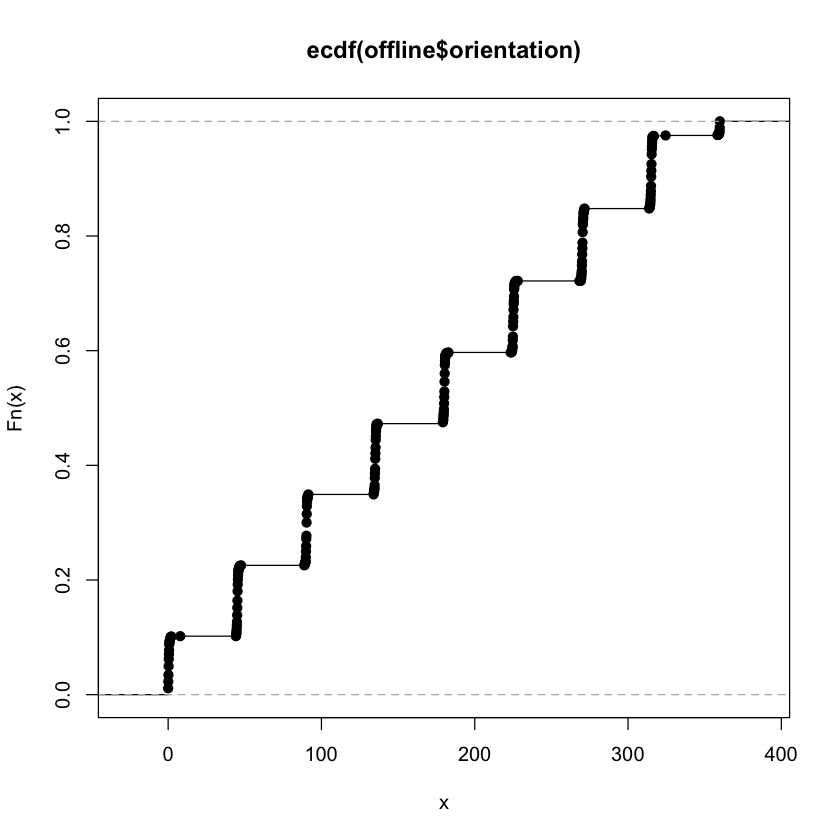

In [16]:
offline = offline[ , !(names(offline) %in% c("scanMac", "posZ"))]
length(unique(offline$orientation))
plot(ecdf(offline$orientation))

*Table 1. Empirical CDF of Orientation for the Hand-Held Device* 

In Table 2, we see a density plot of the orientation angles (after rounding). The x-axis shows us the degree of orientation and the y-axis is the proportion. Each of the angles have roughly eequal proportions. Since there is a little bit of variation within each orientation, the orientations need to be rounded. The roundOrientation function rounds the angles and will now make it easier to use in the calculations. If the rounding had not worked, we would see an actual box for the boxplots in Table 2 indicating spread. 

In [17]:
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

offline$angle = roundOrientation(offline$orientation)

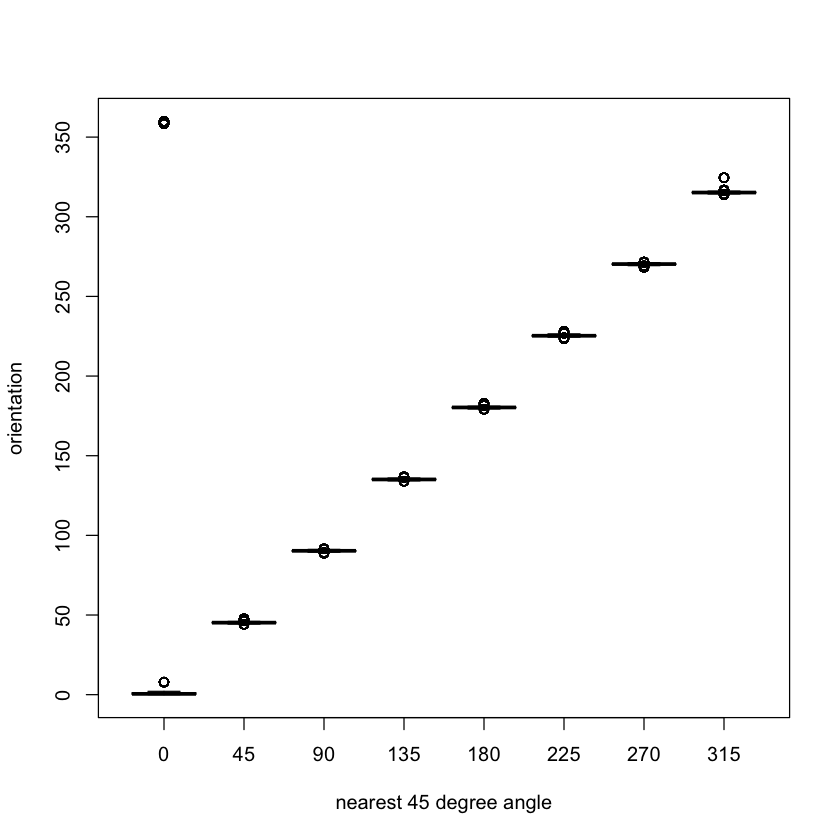

In [18]:
with(offline, boxplot(orientation ~ angle, xlab = "nearest 45 degree angle", ylab="orientation")) 

*Table 2. Boxplots of Orientation for the Hand-Held Device.* 

Now, we need to examine the MAC addresses. This first block of counts the number of unique MAC addresses and the number of unique channels and displays them.

In [19]:
c(length(unique(offline$mac)), length(unique(offline$channel)))
table(offline$mac)

[1] 12  8


00:04:0e:5c:23:fc 00:0f:a3:39:dd:cd 00:0f:a3:39:e0:4b 00:0f:a3:39:e1:c0 
              418            145619             43508            145862 
00:0f:a3:39:e2:10 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
            19162            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 00:30:bd:f8:7f:c5 00:e0:63:82:8b:a9 
           121325            122315               301               103 

There are 12 MAC addresses and 8 channels. The floor plan shows that there are only 6 access points. This indicates that there were more access points that weren't part of the testing area or the floor plan. Looking at the table above the first and last two MAC address have a very different count than the others. This is because these MAC address were not near or working the whole time during the data collection period. These MAC addresses need to be removed from the dataset. 

We will keep the top seven MAC addresses. After deleting the MAC addresses with a low number of observations, there are approximately 915K observations left. The channels also have a one-to-one correspondance with the channels, so we can now delete the channel variable from the data set.

In [20]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]
offline = offline[ offline$mac %in% subMacs, ]

macChannel = with(offline, table(mac, channel))
apply(macChannel, 1, function(x) sum(x > 0))

offline = offline[ , "channel" != names(offline)]

00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1

Now, the position variables need to be examined, posX and posY. We have the number of unique combinations of x and y coordinates. There are 310 empty positions and hence, we can delete them. We end with 166 locations from which signals were read. We are also determining the number of observations from each location. There are around 5500 counts from each location. Table 3 gives us a visualization of the count and physical location of the count on the floor plan. 

In [21]:
locDF = with(offline, by(offline, list(posX, posY), function(x) x))
length(locDF)
sum(sapply(locDF, is.null))
    
locDF = locDF[ !sapply(locDF, is.null) ]
length(locDF)

[1] 476

[1] 310

[1] 166

In [22]:
locCounts = sapply(locDF, nrow)
locCounts = sapply(locDF, 
                   function(df) 
                     c(df[1, c("posX", "posY")], count = nrow(df)))

class(locCounts)
dim(locCounts)
locCounts[ , 1:8]

[1] "matrix"

[1]   3 166

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
posX  0    1    2    0    1    2    0    1   
posY  0    0    0    1    1    1    2    2   
count 5505 5505 5506 5524 5543 5558 5503 5564

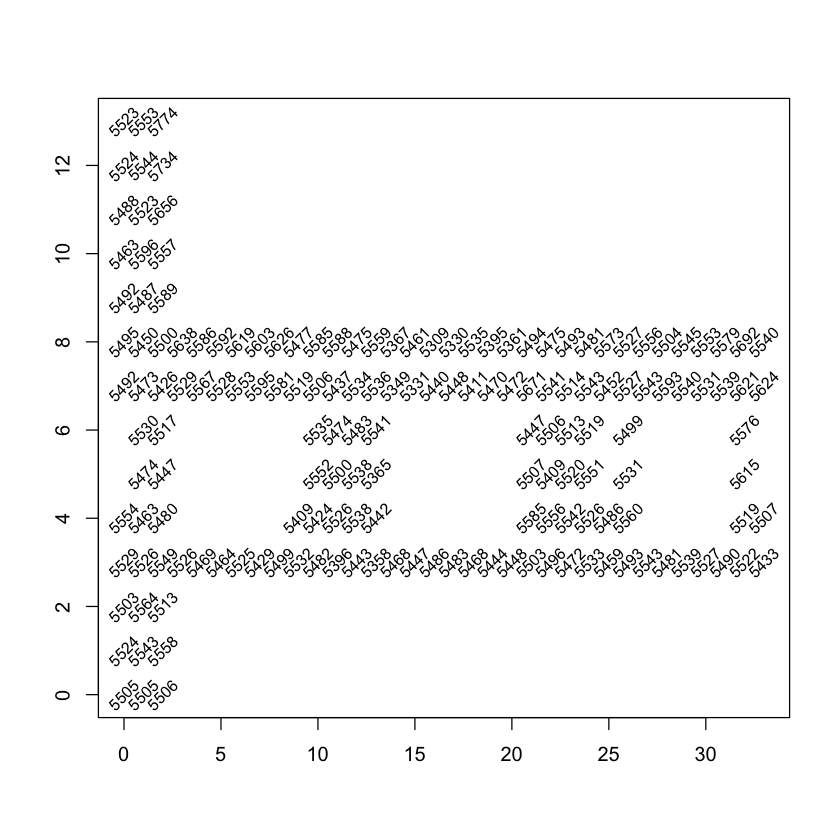

In [23]:
#Visualize the 166 counts by adding the counts as text in their respective locations
locCounts = t(locCounts) 
plot(locCounts, type = "n", xlab ="", ylab ="") 
text(locCounts, labels = locCounts[,3], cex = .8, srt = 45)

*Table 3. Counts of Signals at Each Position.*

The readData function combines the steps we did above to get to this point. We also ran a check to ensure the two data frames match (from the two methods we used to clean the data). Now that the data frames match, three sets of boxplots will be created. The first set will include all of the MAC addresses, the second will exclude the 00:0f:a3:39:dd:cd address, and the final set with exclude 00:0f:a3:39:e1:c0.

In [24]:
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [25]:
offlineRedo = readData()
identical(offline, offlineRedo)

[1] TRUE

## Signal Strength Analysis

Table 4 shows boxplots of the signal strength by position. Each panel is a different MAC address. Later in this analysis, we will be excluding and including certain MAC addresses, but for now we will look at all seven. The analysis presented in Nolan and Lang only display six because their analysis is focus on excluding the MAC address ending in cd because it was determined that it adds no value. In the plots below, it seems like there is some variability within the plots. Some summary statistics for the signal strenghth is also given below. The mean is approximately -60.

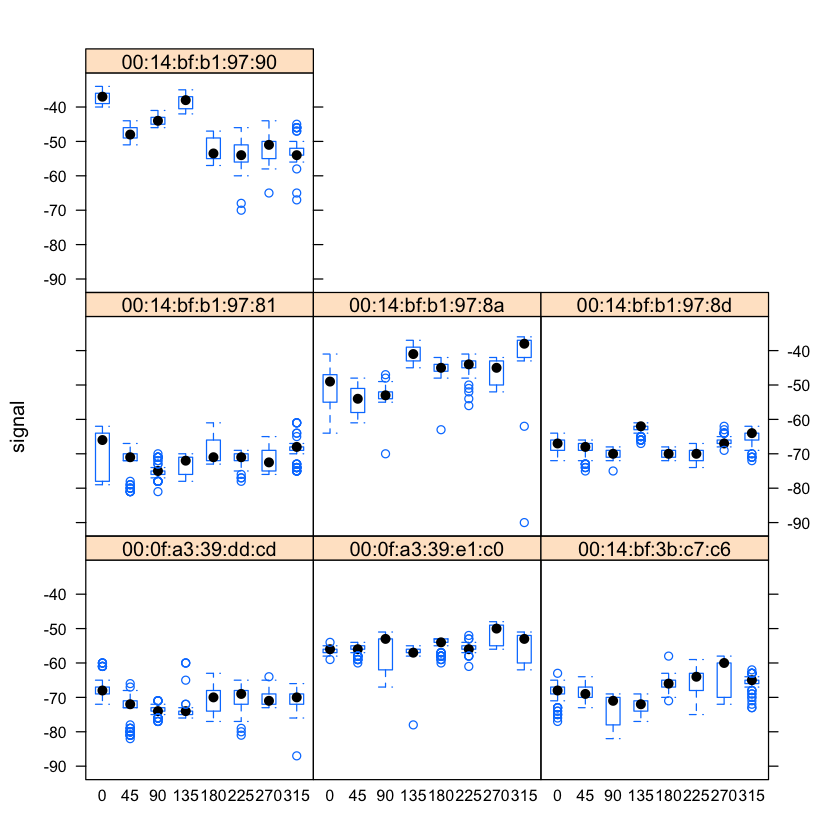

In [26]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12, 
       layout = c(3,3))

*Table 4. Signal Strength by Angle for Each Access Point*

In [27]:
table(offline$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
           145619            145862            126529            120339 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           132962            121325            122315 

In [28]:
summary(offline$signal)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    -98     -67     -59     -60     -53     -25 

Next, the density plots are created to determine if the the observations are normally distributed. For the most part every thing looks good but it is worth noting that they center of distribution changes based on the angle of the device.

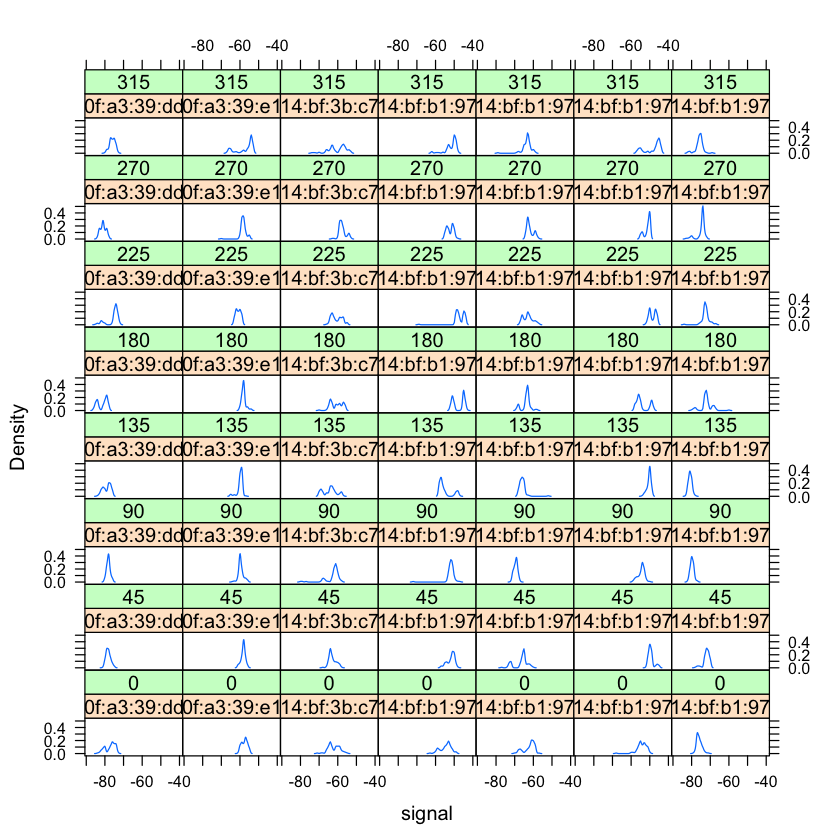

In [29]:
densityplot( ~ signal | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4,
             bw = 0.5, plot.points = FALSE)

*Table 5. Distribution of Signal by Angle for Each Access Point with no exclusions*

## Analysis excluding MAC address 00:0f:a3:39:dd:cd

Here, we are creating a data frame excluding the 00:0f:a3:39:dd:cd MAC address. posXY is a factor that contains all unique combinations of (x,y) pairs at 166 locations. Next, we are creating a list of data frames for every combination of (x, y) angle and access point. Then, we create a function to summarize signal data by AP, location and angle.

In [30]:
offline_cd = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
offline_cd$posXY = paste(offline_cd$posX, offline_cd$posY, sep = "-")

In [31]:
byLocAngleAP = with(offline_cd, 
                    by(offline_cd, list(posXY, angle, mac), 
                       function(x) x))

In [32]:
signalSummary_cd = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

Here, we are just double checking that the data frame excludes the MAC address ending in cd. Then we are creating a new data frame of the summary statistics.

In [33]:
table(offline_cd$mac)


00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
           145862            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           121325            122315 

In [34]:
offlineSummary_cd = do.call("rbind", signalSummary_cd)

Table 6 is a plot of the SD signal by mean signal. It is interesting to notice that weaker signals have less variability than stronger ones.

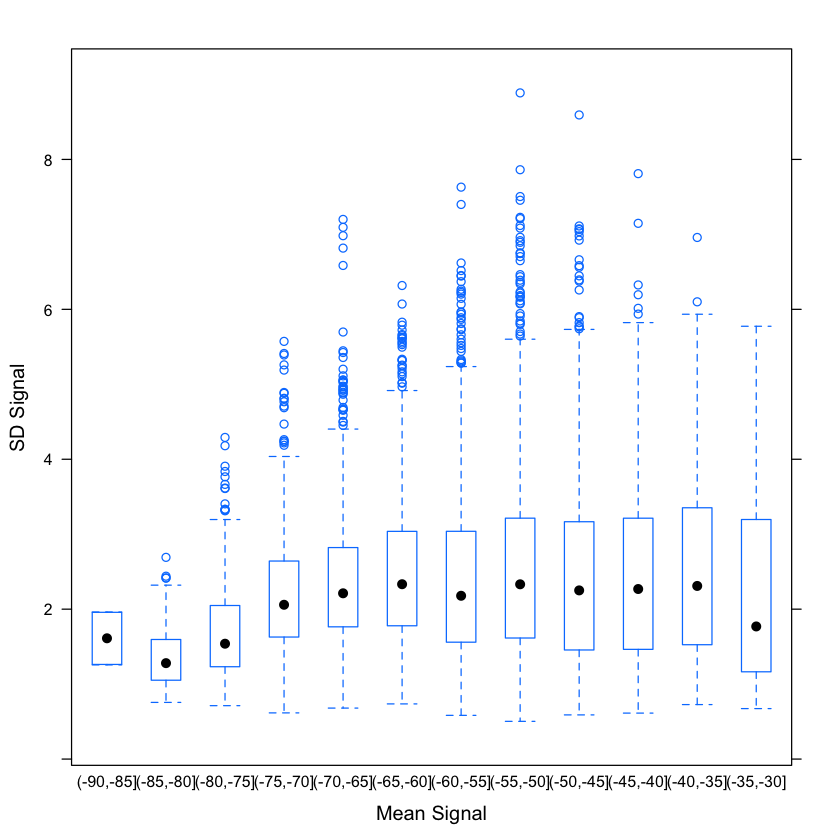

In [35]:
#creation of boxplot to model SD of signal strength
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary_cd, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Signal", ylab = "SD Signal")

*Table 6. SD of Signal Strength by Mean Signal Strength excluding 00:0f:a3:39:dd:cd.*

Table 7 shows a smoothed scatter plot of the mean and median by location, angle, and AP vs. the number of observations. The darker blue indicates more observations. Notice that most of the differences are closer to zero. We are also plotting a LOESS curve on the same plot to locally smooth the difference between the mean and the median. The LOESS curve in this case is fairly flat, which indicates that there isn't much of a difference between the mean and the median for the signal strength.

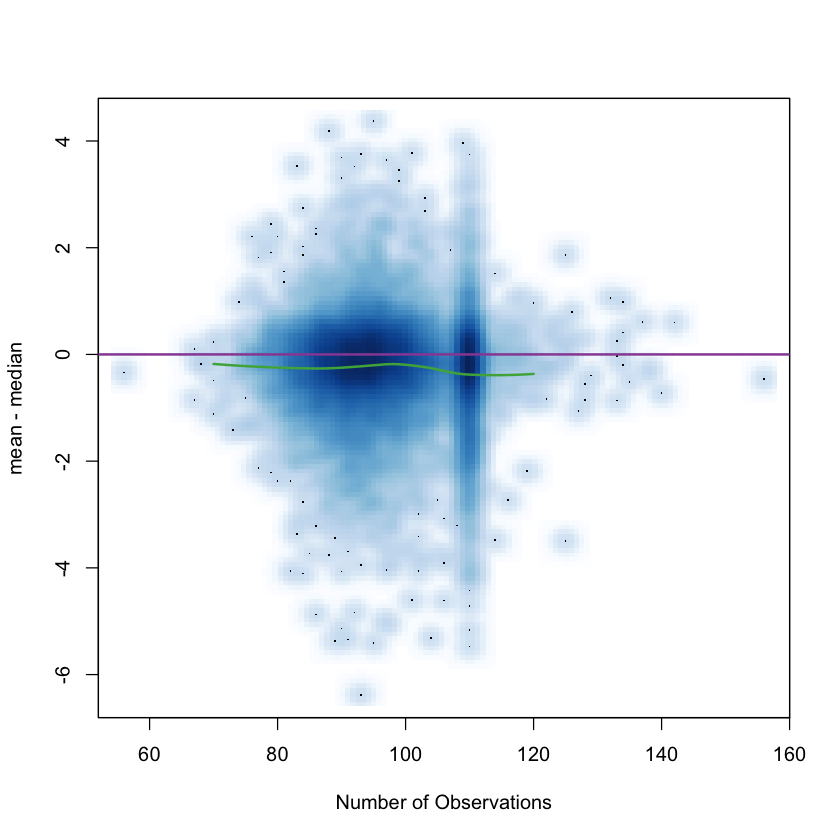

In [36]:
with(offlineSummary_cd,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary_cd,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

*Table 7. Comparison of Mean and Median Signal Strength excluding 00:0f:a3:39:dd:cd*

### Relationship Between Signal and Distance

In this section, we will explore the relationship between signal and distance for one AP. First we are selecting one angle and MAC address. We will start by creating a heatmap for one specific MAC address and the angles. Notice that the concentrated areas indicate where the access point is located.

In [37]:
oneAPAngle = subset(offline_cd, mac == subMacs[5] & angle == 0) 
oneAPAngle = subset(offlineSummary_cd, mac == subMacs[5] & angle == 0)

In [38]:
#the packages fields, maps, and spam must be installed
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

Warning message:
“package ‘fields’ was built under R version 3.3.2”Loading required package: spam
Loading required package: grid
Spam version 1.4-0 (2016-08-29) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps


[1] 6400    2


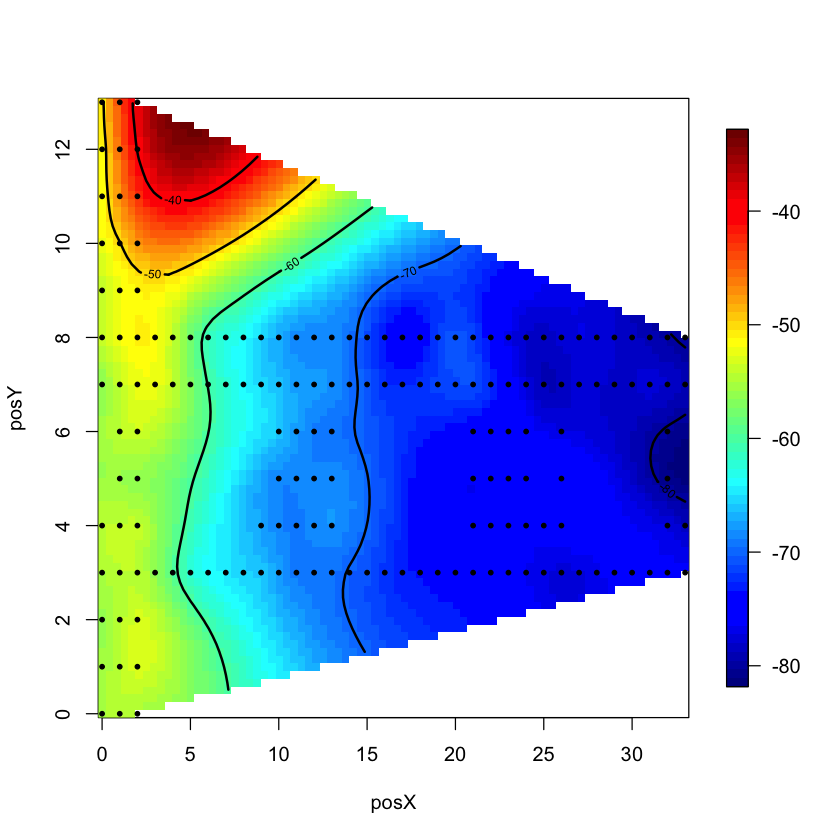

In [39]:
vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

*Table 7. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:dd:cd*

The surfaceSS function allows us to get contour plots for specified APs and angles. The parCur object contains plotting parameters for surfaceSS. The parameters are set up to plot four plots on the same canvas. The MAC addresses are returned and they correspond to the top two and bottom two plots. This is displayed in Table 8. The top two plots represent the signal strength for the 00:14:bf:b1:97:90 MAC address while the bottom two represent the 00:0f:a3:39:e1:c0 MAC address. The two angles remain the same for both MAC addresses. 

In [40]:
#creating heatmap function
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

[1] 6400    2
[1] 6400    2
[1] 6400    2
[1] 6400    2


$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


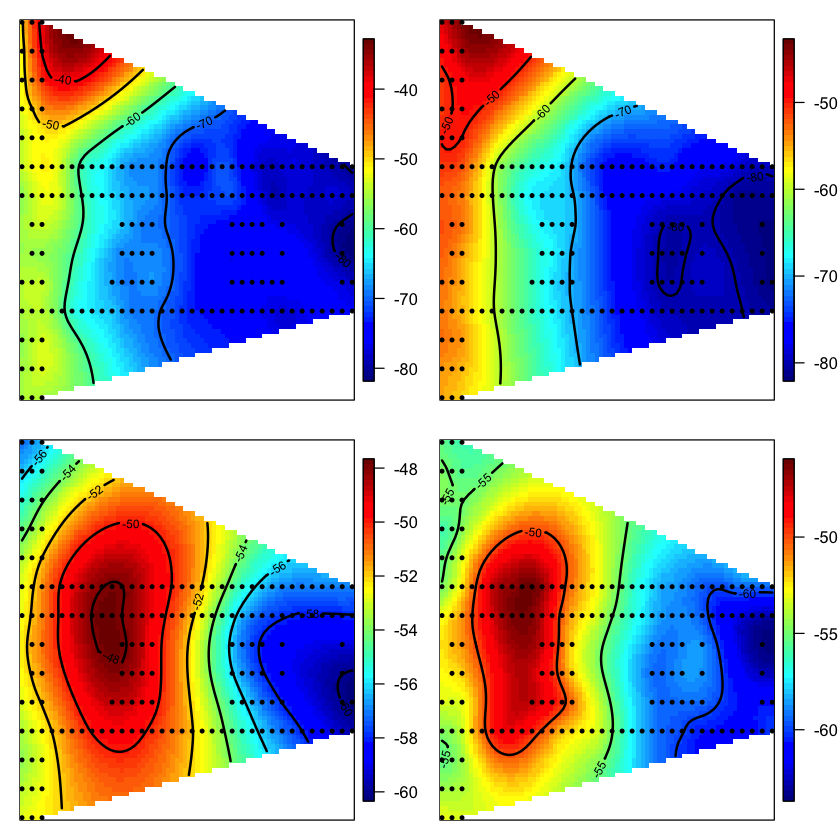

In [41]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary_cd))
 
par(parCur)

*Table 8. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:dd:cd*

The second MAC address is deleted because it looks very similar to the first. The AP matrix contains the relevant positions of the access points on the floor plan. The output below shows the MAC address and its corresponding coordinates.

In [42]:
offlineSummary_cd = subset(offlineSummary_cd, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

The next block of code gives us a scatterplot of the relationship between the signal strength and the distance of each access point from the receiver. The differences are computed and the Euclidean distance is calculated for each access plot. The resulting plot shows the relationship between signal and distance for each of the 48 combinations of AP and angle. Notice that the shape is fairly consistent across all combinations.

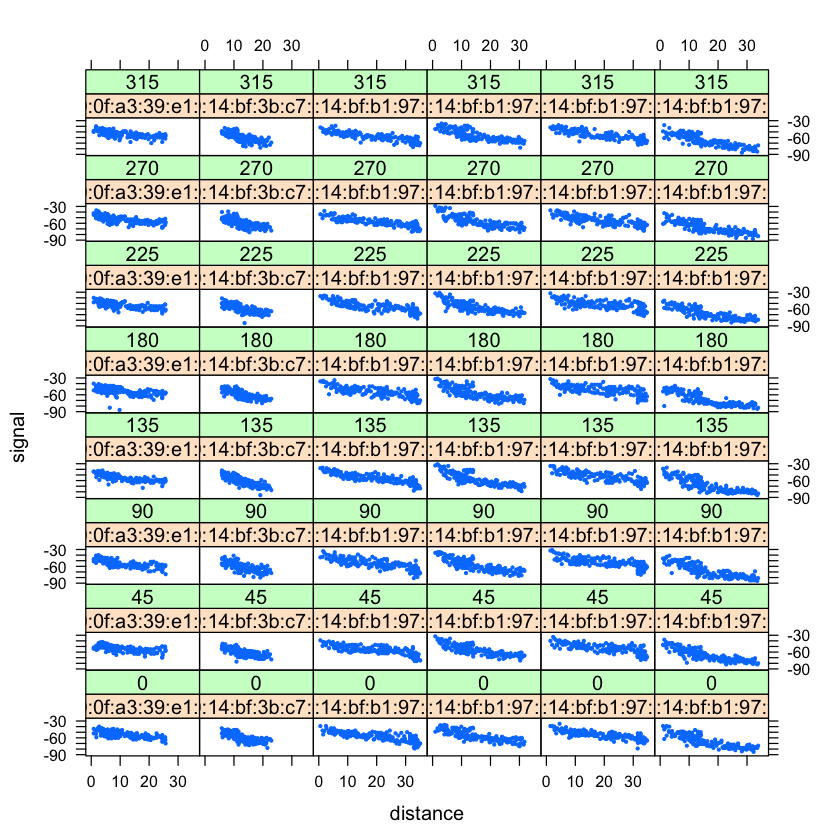

In [43]:
diffs = offlineSummary_cd[ , c("posX", "posY")] - 
          AP[ offlineSummary_cd$mac, ]

offlineSummary_cd$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary_cd, pch = 19, cex = 0.3,
       xlab ="distance")

*Table 9. Signal Strength vs. Distance to Access Point Excluding 00:0f:a3:39:dd:cd.*

### K-Nearest Neighbors Approach (k-NN)

In this next section, we will be using k-NN to estimate the location of the device from the strength of the signal that is detected between the device and the numerous access points we have. We will be using our training data set (offline) and finally bringing in the testing data set (online). The online data set contains the unknown locations. Our goal is to estimate the locations based on the training data. In the end, we will assess the accuracy of the predictions and determine which MAC address to include or exclude. Currently we are still excluding the 00:0f:a3:39:dd:cd MAC address. We have 60 unique test locations.

In [44]:
macs = unique(offlineSummary_cd$mac)

In [45]:
online = readData("online.final.trace.txt", subMacs = macs)

In [46]:
online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

[1] 60

The output below shows a summary of the number of signal strenghts recorded at each location. The summary shows us that the signal strengths were recorded with one orientation for each location.

Next we are reorganizing the data set in a different structure for eas of use. The average singal strength at each location is given. We are keeping only the useful variables in the data set. 

In [47]:
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

dim(onlineSummary)

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 593   0   0   0   0
  0.15-9.42    0   0 606   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 573   0   0
  0.47-8.2   590   0   0   0   0   0   0   0
  0.78-10.94 586   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 583   0   0   0

[1] 60 11

Next, our goal is to find records in the offline data set that have similar orientations to the unknown observations because it can impact the strength of the signal. In order to accomplish this, we found records with an orientation that is in a specific range of the unknown observation's orientation. Here, m is the number of angles to keep between 1 and 5. It is used to create the subset of the angles we desire.

In [48]:
names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [49]:
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
      
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

In [50]:
offlineSubset_cd = 
  offlineSummary_cd[ offlineSummary_cd$angle %in% angles, ]

In [51]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset_cd, varSignal = "avgSignal")

In [52]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset_cd, varSignal = "avgSignal")
}

In [53]:
train130 = selectTrain(130, offlineSummary_cd, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -55               -67               -65              
0-1  0-1   0     1   -52               -65               -65              
0-10 0-10  0    10   -54               -64               -68              
0-11 0-11  0    11   -55               -65               -66              
0-12 0-12  0    12   -55               -67               -70              
0-13 0-13  0    13   -54               -71               -72              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -66               -56              
0-1  -38               -67               -57              
0-10 -45               -66               -53              
0-11 -49               -67               -55              
0-12 -44               -71               -54              
0-13 -47               -70               -57

[1] 166

Now, we have the training data set complete and ready to use for location prediction. The findNN() function will calculate the distances from the new point to all the observations in the training data set. 

In [54]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [55]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

Here, we are testing the above functions with 3 nearest neighbors and 3 orientations along with 1 nearest neighbor.

In [56]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 1)

In [57]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

In [58]:
trainPoints = offlineSummary_cd[ offlineSummary_cd$angle == 0 & 
                              offlineSummary_cd$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

The plots below (Table 10 and 11) show the predicted and actual locations for 3 and 1 nearest neighbors. The red lines connect the test locations to the predicted locations. Just by looking at the plot, we can see that when k = 3, the predictions seem to be better.

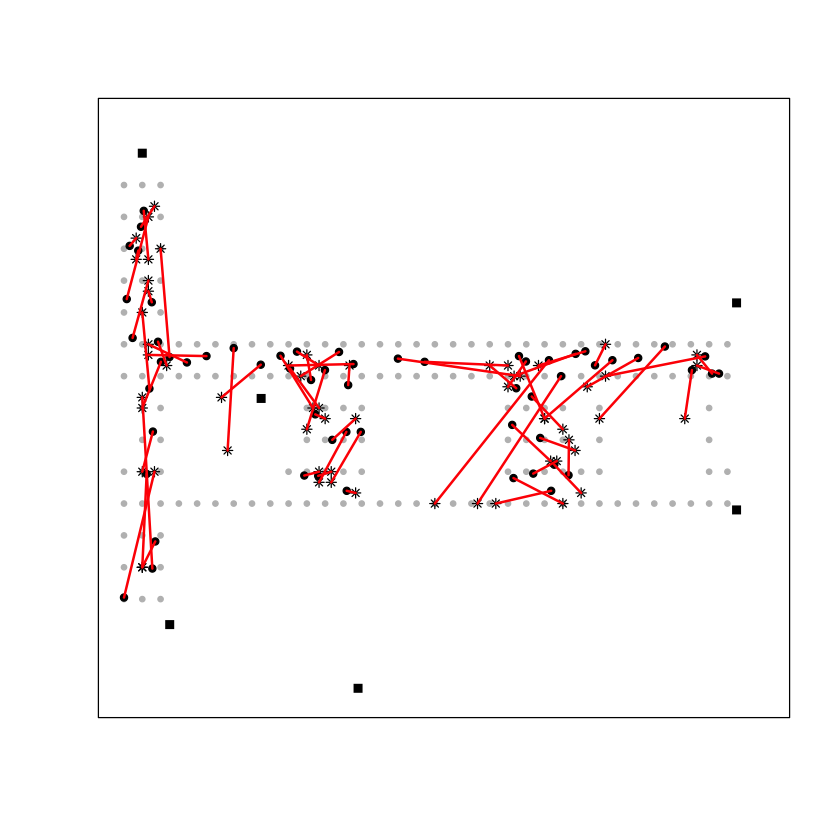

In [59]:
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 10. Floor Plan with Predicted and Actual Locations with 3 Nearest Neighbors.*

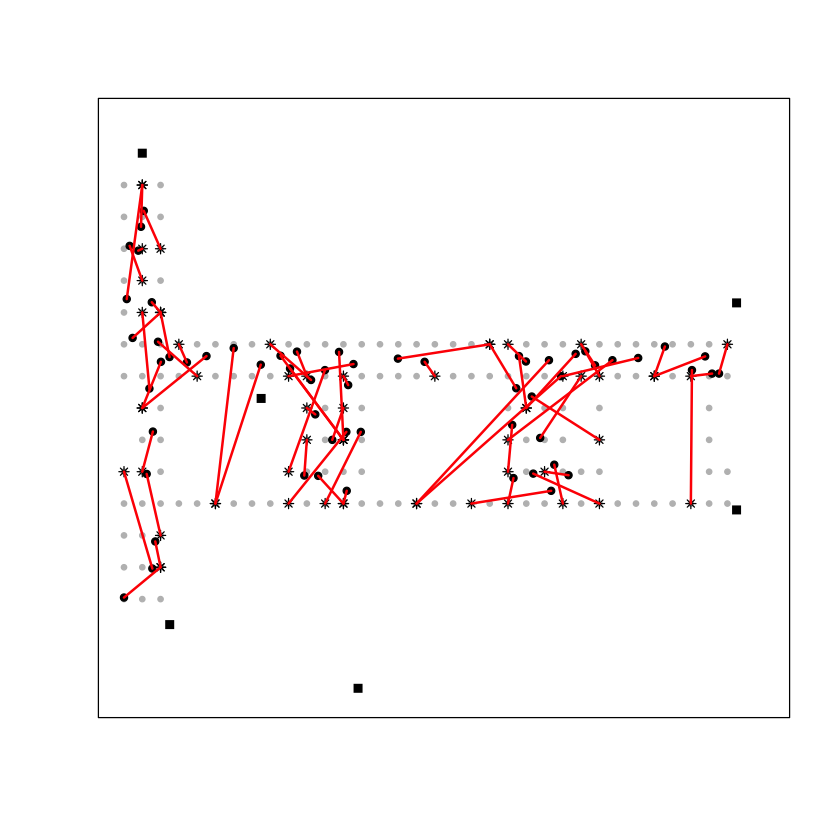

In [60]:
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 11. Floor Plan with Predicted and Actual Locations with 1 Nearest Neighbor.*

In [61]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 579 483

The errors calculated above for k=1 and k=3 are approximately 579 and 483. This tells us that when k=3, we have a lower error and therefore, a better location prediction model.

When choosing the optimal number of neighbors it is important to split the data in a training and test data sets. This prevents the likelihood of over fitting. The method used to develop the training and test data sets in the next section is v-fold cross-validation. We will simply divide the data in 'v' (11) equal parts and train the model on all but that subset. This is repeated and all prediction errors are aggregated.

In [62]:
v = 11
permuteLocs = sample(unique(offlineSummary_cd$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))
onlineFold = subset(offlineSummary_cd, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

There is an error in dividing the dataset into equal parts. Specifically, 11 does not divide in to the 166 locations evenly. When this happens the remaining observations are left out of the variable.

In [63]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Redefining reshapeSS to select one angle in each location at random.

In [64]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary_cd = reshapeSS(offline_cd, keepVars = keepVars, 
                            sampleAngle = TRUE)

In [65]:
onlineFold = subset(onlineCVSummary_cd, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_cd,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 94

This created the first fold and ran an error calculation with an output around 200. Remember the folds are chosen at random so it unlikely we will get the same error twice. 

Now we are going to loop through and create the number of folds specified by 'v'. We also specify the range of neighbors (0-20).

In [66]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary_cd, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_cd,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

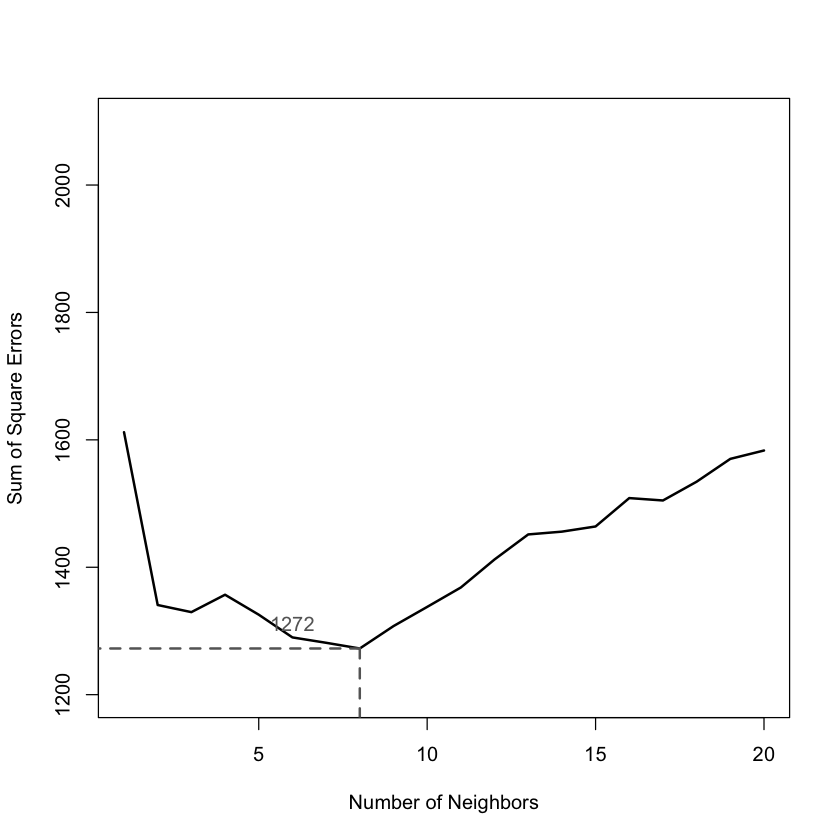

In [67]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

*Cross Validated Selection of k*

The above graph depicts the sum of squares error for each of the number of neighbors. Clearly looking at the chart, eight neighbors yields the best results. Going forward we will uses five neighbors for comparing this dataset to the others. 

In [68]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 8)

calcError(estXYk5, actualXY)

[1] 425

Error calcuation for eight neighbors.

The function below is a more efficient way of calculating all of the folds and errors for those folds. We will be using this function in the future.

In [69]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

## Analysis excluding MAC address 00:0f:a3:39:e1:c0

In [70]:
table(offline$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
           145619            145862            126529            120339 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           132962            121325            122315 

In [71]:
offline_c0 = offline[ offline$mac != "00:0f:a3:39:e1:c0", ]
table(offline_c0$mac)


00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
           145619            126529            120339            132962 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           121325            122315 

The data set offline_c0 is the complete but is without the MAC address ending in c0.

In [72]:
offline_c0$posXY = paste(offline_c0$posX, offline_c0$posY, sep = "-")

In [73]:
byLocAngleAP = with(offline_c0, 
                    by(offline_c0, list(posXY, angle, mac), 
                       function(x) x))

In [74]:
signalSummary_c0 = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

In [75]:
offlineSummary_c0 = do.call("rbind", signalSummary_c0)

In [76]:
table(offlineSummary_c0$mac)


00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
             1328              1328              1328              1328 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
             1328              1328 

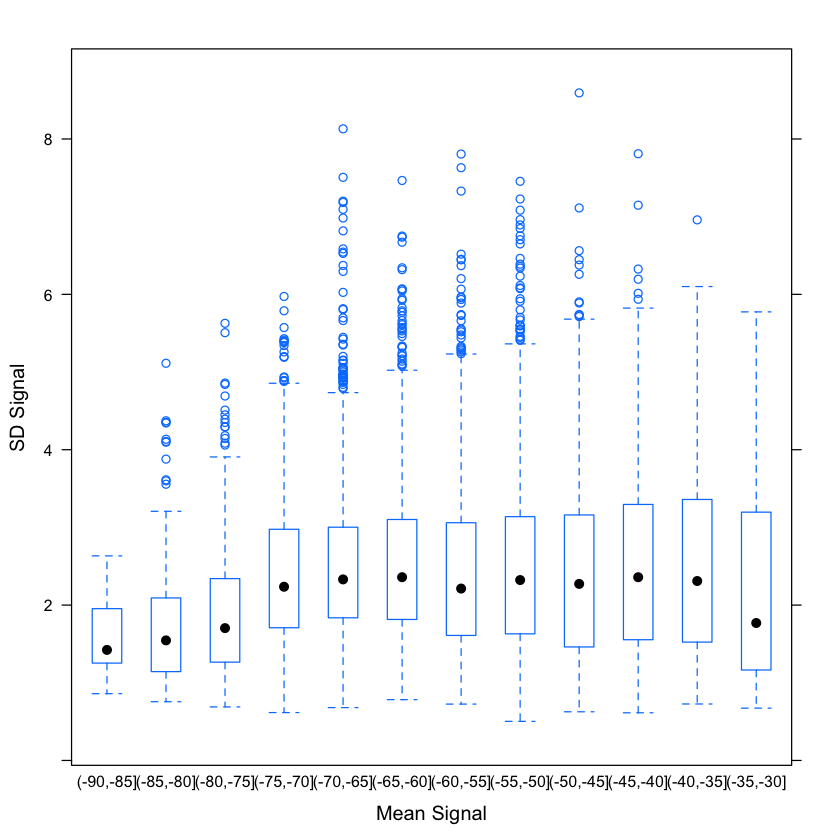

In [77]:
library(lattice)
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary_c0, 
       subset = mac != "00:0f:a3:39:e1:c0",
       xlab = "Mean Signal", ylab = "SD Signal")

*Table 12. SD of Signal Strength by Mean Signal Strength excluding 00:0f:a3:39:e1:c0*

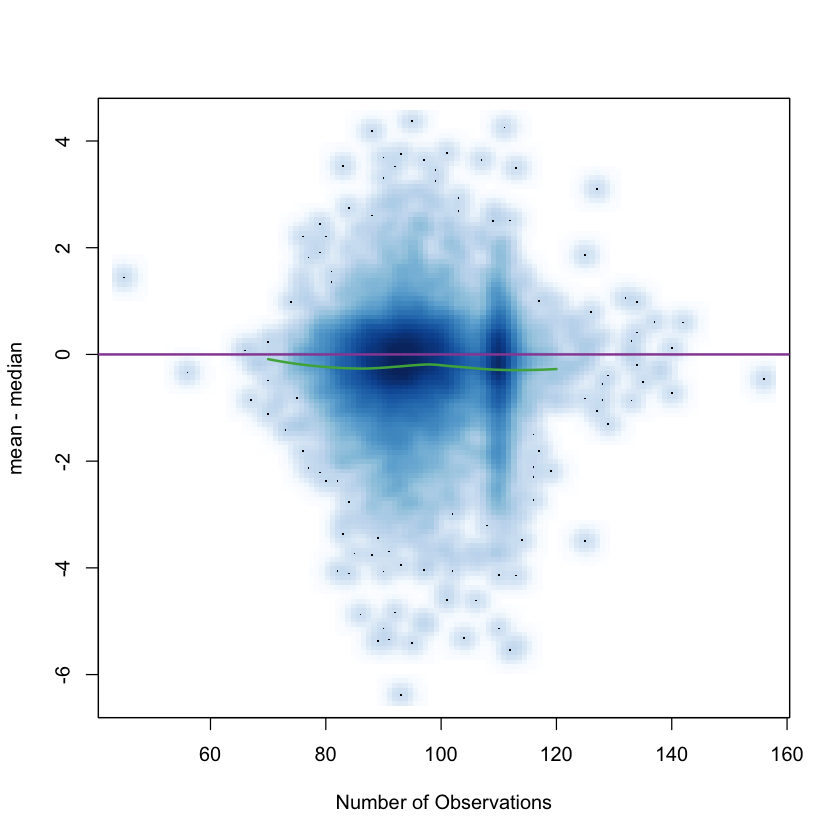

In [78]:
with(offlineSummary_c0,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary_c0,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

*Table 13. Comparison of Mean and Median Signal Strength excluding 00:0f:a3:39:e1:c0*

In [79]:
#oneAPAngle = subset(offline_c0, mac == subMacs[5] & angle == 0) 
oneAPAngle = subset(offlineSummary_c0, mac == subMacs[5] & angle == 0)

In [80]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

The next section contains several heat maps in the same fashion as earlier. The deeper blue the graph is the closer it is to an access point.

[1] 6400    2


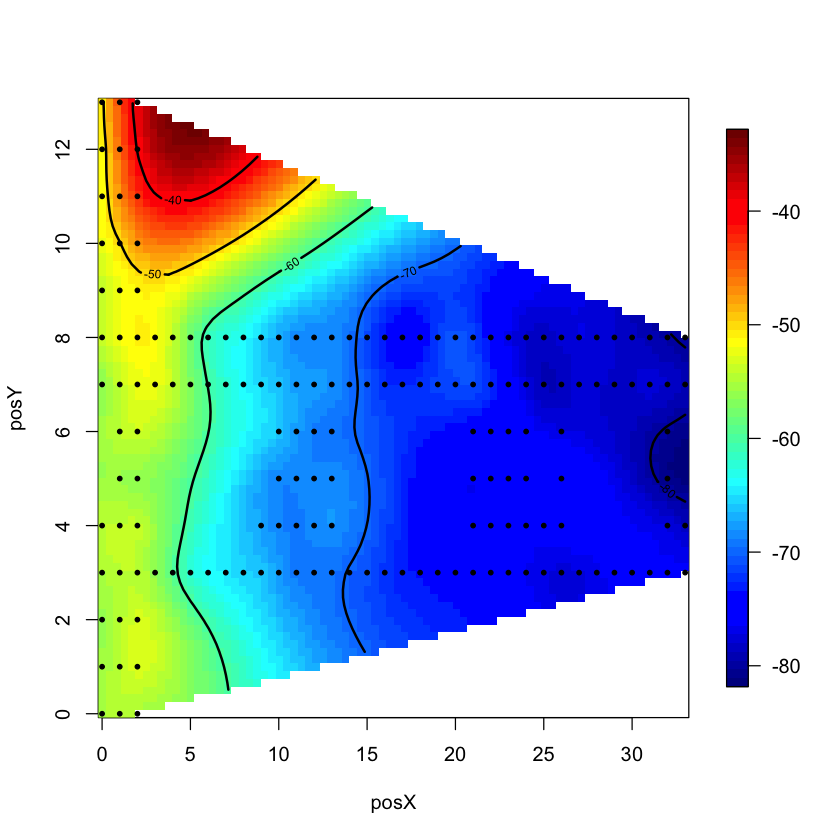

In [81]:
vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

*Table 14. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:e1:c0*

In [82]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

[1] 6400    2
[1] 6400    2
[1] 6400    2
[1] 6400    2


$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


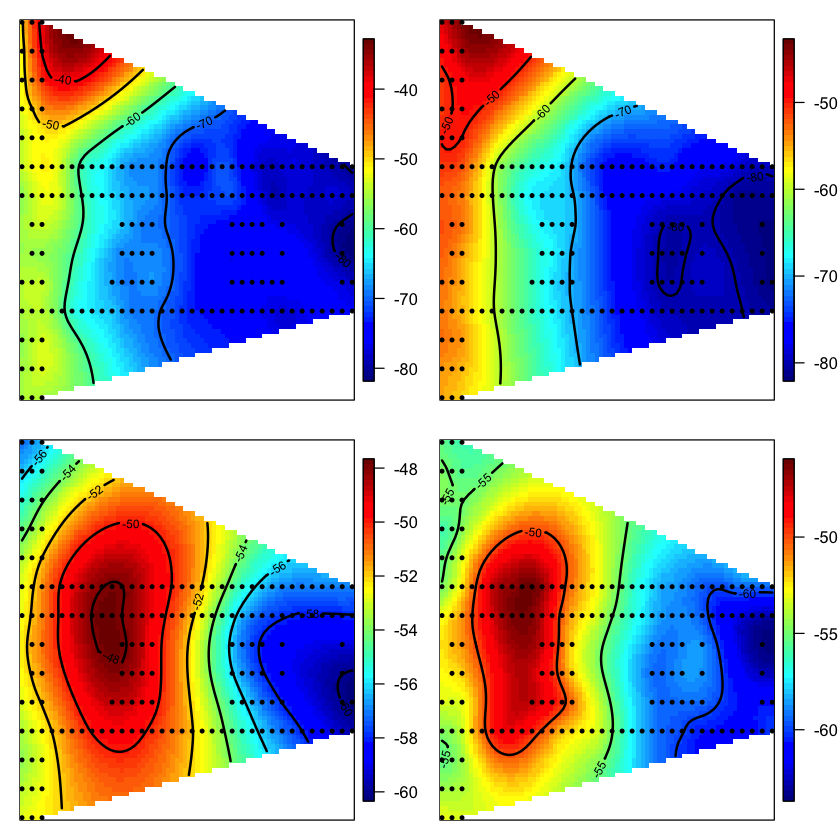

In [83]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary_c0))
 
par(parCur)

*Table 15. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:e1:c0*

In [84]:
table(offlineSummary_c0$mac)


00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
             1328              1328              1328              1328 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
             1328              1328 

The output below shows the MAC address and its corresponding coordinates.

In [85]:
offlineSummary_c0 = subset(offlineSummary_c0, mac != subMacs[1])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -1 ], c("x", "y") ))

AP

x    y   
00:0f:a3:39:dd:cd  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

In [86]:
table(offlineSummary_c0$mac)


00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
             1328              1328              1328              1328 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
             1328              1328 

The next block of code gives us a scatterplot of the relationship between the signal strength and the distance of each access point from the receiver. The differences are computed and the Euclidean distance is calculated for each access plot. The resulting plot shows the relationship between signal and distance for each of the 48 combinations of AP and angle. Notice that the shape is fairly consistent across all combinations.

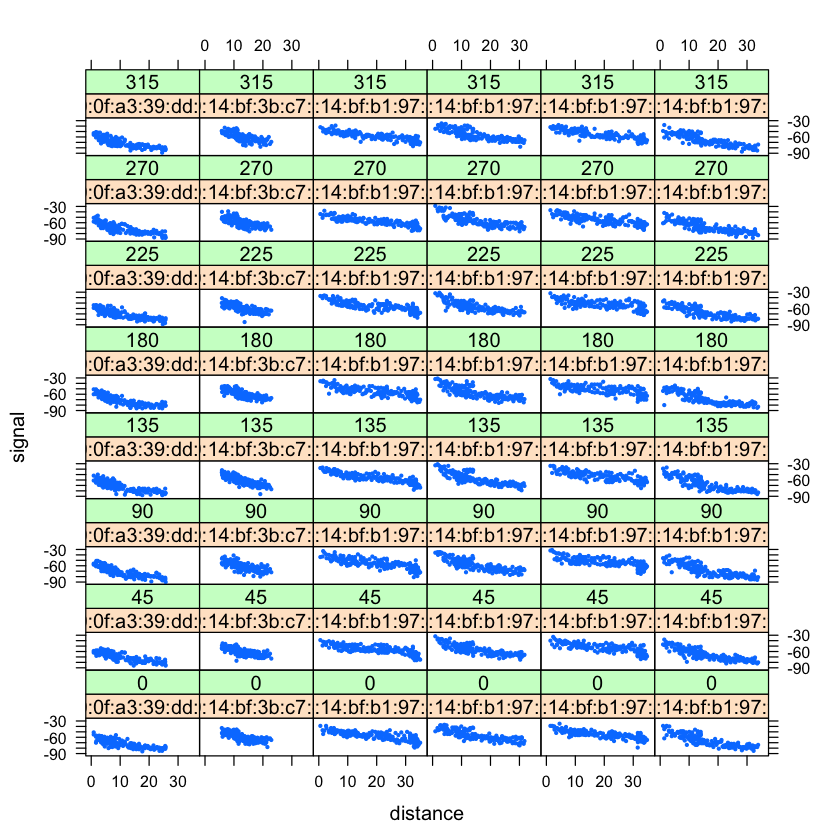

In [87]:
diffs = offlineSummary_c0[ , c("posX", "posY")] - 
          AP[ offlineSummary_c0$mac, ]

offlineSummary_c0$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary_c0, pch = 19, cex = 0.3,
       xlab ="distance")

*Table 16. Signal Strength vs. Distance to Access Point Excluding 00:0f:a3:39:e1:c0*

### K-Nearest Neighbors Approach (k-NN)

In [88]:
macs = unique(offlineSummary_c0$mac)

In [89]:
table(macs)

macs
00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 00:14:bf:b1:97:8a 
                1                 1                 1                 1 
00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1 

In [90]:
online = readData("online.final.trace.txt", subMacs = macs)

In [91]:
online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

[1] 60

Here the data set is being reorganized into a different structure for ease of use.

In [92]:
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

dim(onlineSummary)

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 594   0   0   0   0
  0.15-9.42    0   0 608   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 574   0   0
  0.47-8.2   591   0   0   0   0   0   0   0
  0.78-10.94 585   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 581   0   0   0

[1] 60 11

Finding records in the offline data set that have similar orientations to the unknown observations.

In [93]:
names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [94]:
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
      
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

In [95]:
offlineSubset_c0 = 
  offlineSummary_c0[ offlineSummary_c0$angle %in% angles, ]

In [96]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset_c0, varSignal = "avgSignal")

In [97]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset_c0 = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset_c0, varSignal = "avgSignal")
}

In [98]:
train130 = selectTrain(130, offlineSummary_c0, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:dd:cd 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   -72               -66               -63              
0-1  0-1   0     1   -70               -65               -64              
0-10 0-10  0    10   -70               -66               -69              
0-11 0-11  0    11   -71               -67               -70              
0-12 0-12  0    12   -69               -70               -72              
0-13 0-13  0    13   -73               -71               -73              
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -36               -64               -55              
0-1  -39               -65               -59              
0-10 -45               -67               -50              
0-11 -48               -67               -55              
0-12 -45               -67               -50              
0-13 -43               -69               -54

[1] 166

Now, we have the training data set complete and ready to use for location prediction. The findNN() function will calculate the distances from the new point to all the observations in the training data set.

In [99]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [100]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

Here we are testing the above functions.

In [101]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_c0, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_c0, numAngles = 3, k = 1)

In [102]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

In [103]:
trainPoints = offlineSummary_c0[ offlineSummary_c0$angle == 0 & 
                              offlineSummary_c0$mac == "00:0f:a3:39:dd:cd" ,
                        c("posX", "posY")]

The plots below (Table 17 and 18) show the predicted and actual locations for 3 and 1 nearest neighbors.

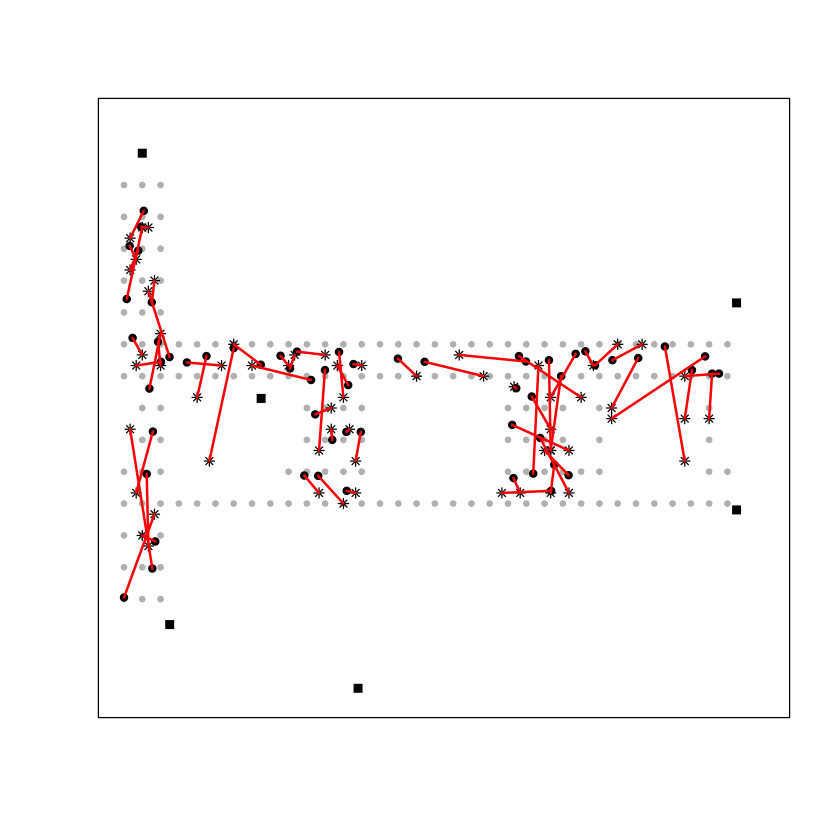

In [104]:
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 17. Floor Plan with Predicted and Actual Locations with 3 Nearest Neighbors.*

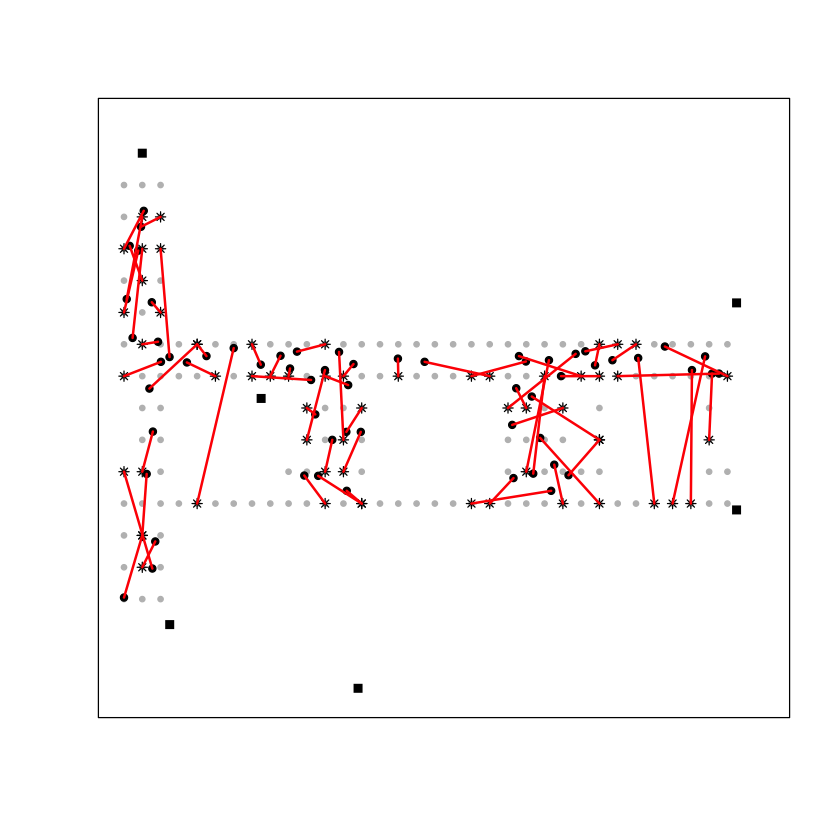

In [105]:
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 18. Floor Plan with Predicted and Actual Locations with 1 Nearest Neighbor.*

In [106]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 412 270

The errors calculated above for k=1 and k=3 are approximately 411 and 270. This tells us that when k=3, we have a lower error and therefore, a better location prediction model.


In the next section we are developing the training and test data sets using v-fold cross-validation.

In [107]:
v = 11
permuteLocs = sample(unique(offlineSummary_c0$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))
onlineFold = subset(offlineSummary_c0, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

There is an error in dividing the dataset into equal parts. Specifically, 11 does not divide in to the 166 locations evenly. When this happens the remaining observations are left out of the variable.

In [108]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

Redefining reshapeSS to select one angle in each location at random.

In [109]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline_c0, keepVars = keepVars, 
                            sampleAngle = TRUE)

In [110]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_c0,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 65

This created the first fold and ran an error calculation with an output around 90. Remember the folds are chosen at random so it unlikely we will get the same error twice.


Now we are going to loop through and create the number of folds specified by 'v'. We also specify the range of neighbors (0-20).

In [111]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_c0,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

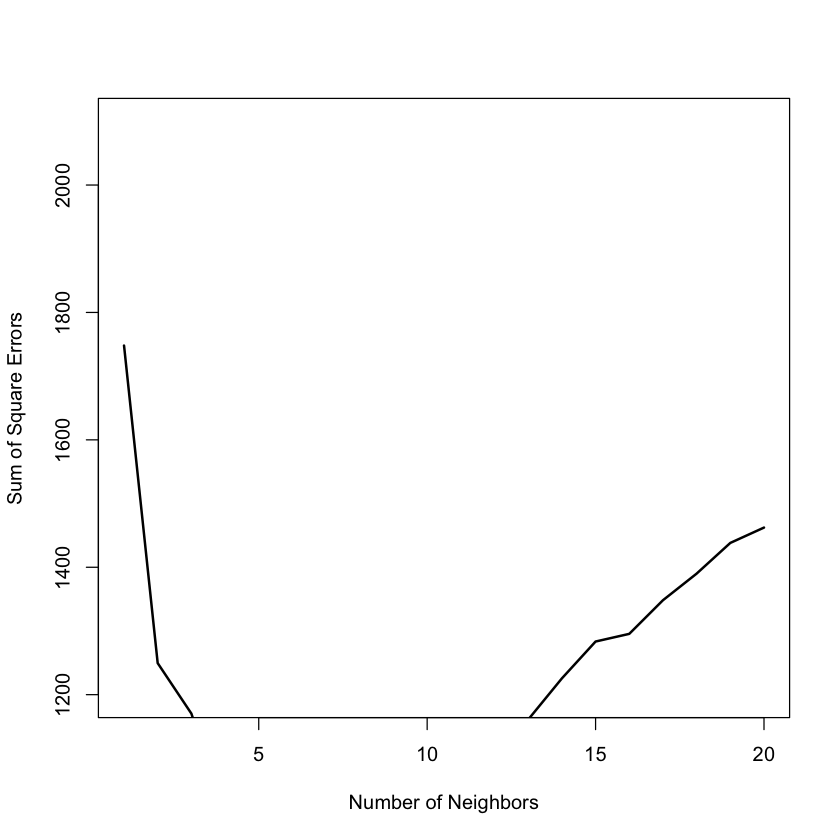

In [112]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

*Table 19. Sum of Square Errors vs. Number of Neighbors*

The above graph depicts the sum of squares error for each of the number of neighbors. Looking at the chart it is clear again that five to eight neighbors yield the best results. Going forward we will uses five neighbors for comparing this dataset to the others.

In [113]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_c0, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 250

Error calcuation for five neighbors.


The function below is a more efficient way of calculating all of the folds and errors for those folds. We will be using this function in the future.

In [114]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

## Analysis including both MAC addresses

In [115]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

In [116]:
byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

In [117]:
signalSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medSignal = median(oneLoc$signal)
           ans$avgSignal = mean(oneLoc$signal)
           ans$num = length(oneLoc$signal)
           ans$sdSignal = sd(oneLoc$signal)
           ans$iqrSignal = IQR(oneLoc$signal)
           ans
           })

In [118]:
table(offline$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
           145619            145862            126529            120339 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
           132962            121325            122315 

In [119]:
offlineSummary = do.call("rbind", signalSummary)

In [120]:
table(offlineSummary$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
             1328              1328              1328              1328 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
             1328              1328              1328 

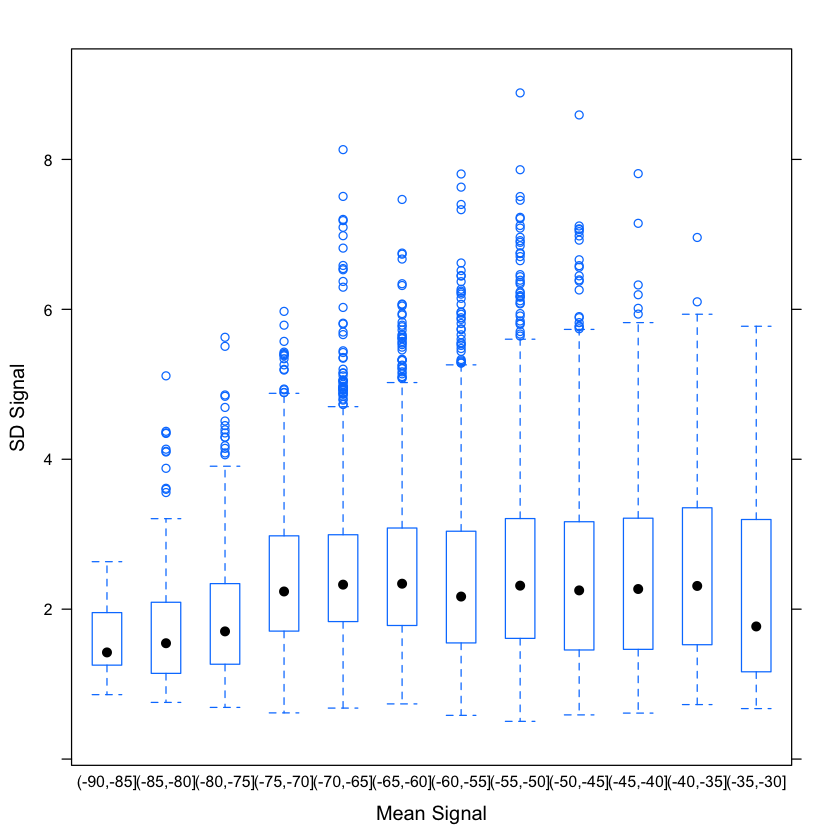

In [121]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
       data = offlineSummary,
       xlab = "Mean Signal", ylab = "SD Signal")

*Table 20. SD of Signal Strength by Mean Signal Strength with no exclusions*

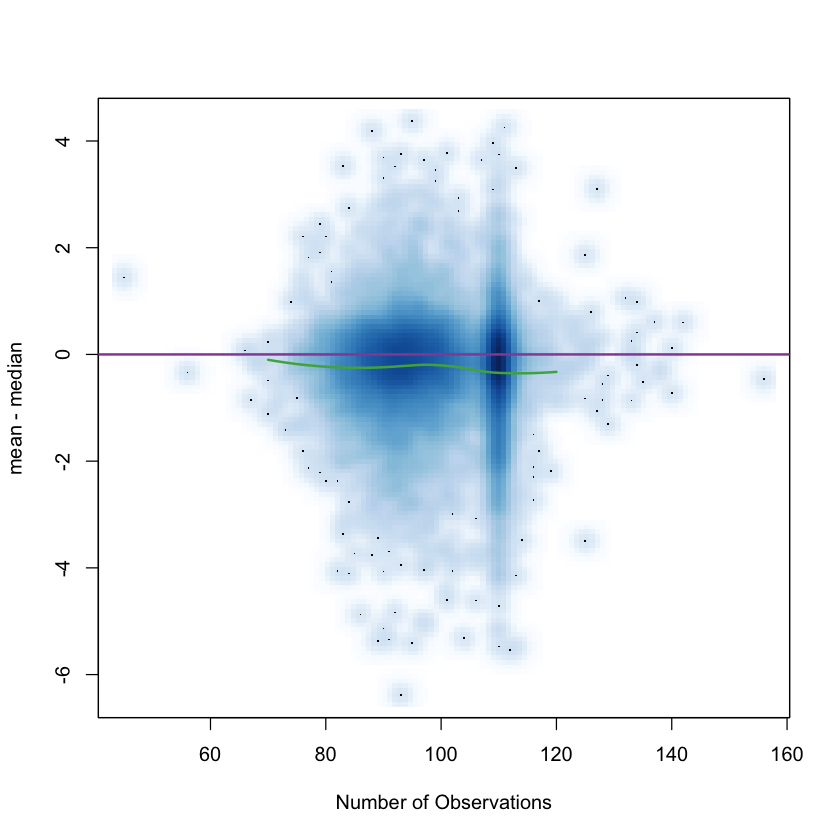

In [122]:
with(offlineSummary,
     smoothScatter((avgSignal - medSignal) ~ num,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)
lo.obj = 
  with(offlineSummary,
       loess(diff ~ num, 
             data = data.frame(diff = (avgSignal - medSignal),
                               num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

*Table 21. SD of Signal Strength by Mean Signal Strength with all MAC addresses*

In [123]:
oneAPAngle = subset(offline, mac == subMacs[5] & angle == 0) 
oneAPAngle = subset(offlineSummary, mac == subMacs[5] & angle == 0)

In [124]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgSignal)

The next section contains several heat maps in the same fashion as earlier. The deep blue the graph is the closer it is to an access point

[1] 6400    2


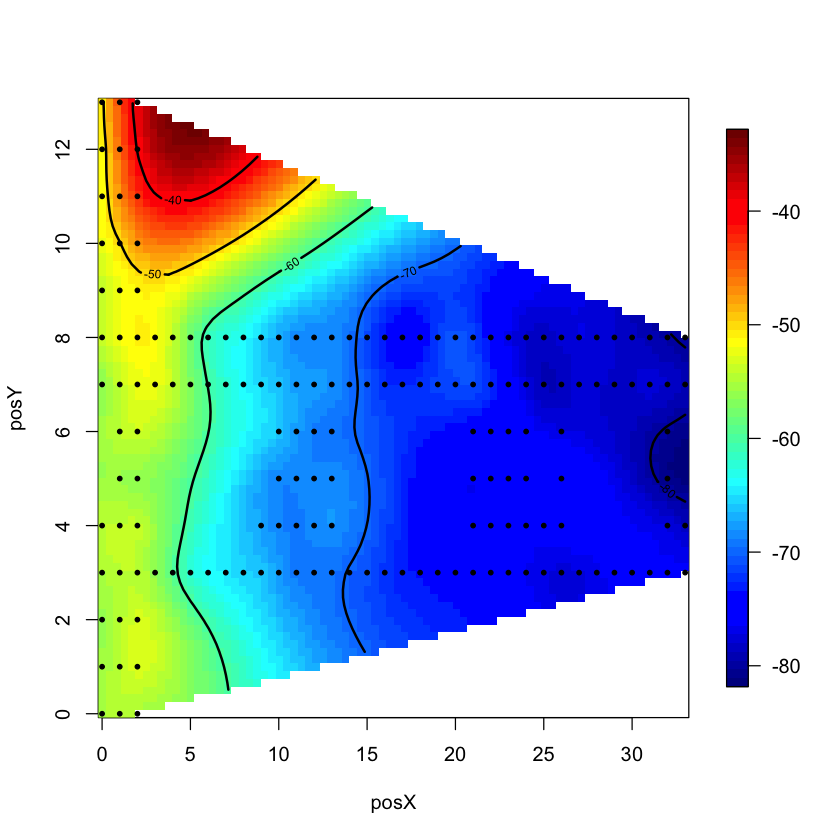

In [125]:
vizSmooth = predictSurface(smoothSS)
plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

*Table 22. Heatmap of the One MAC Address and Angle Excluding*

In [126]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

[1] 6400    2
[1] 6400    2
[1] 6400    2
[1] 6400    2


$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


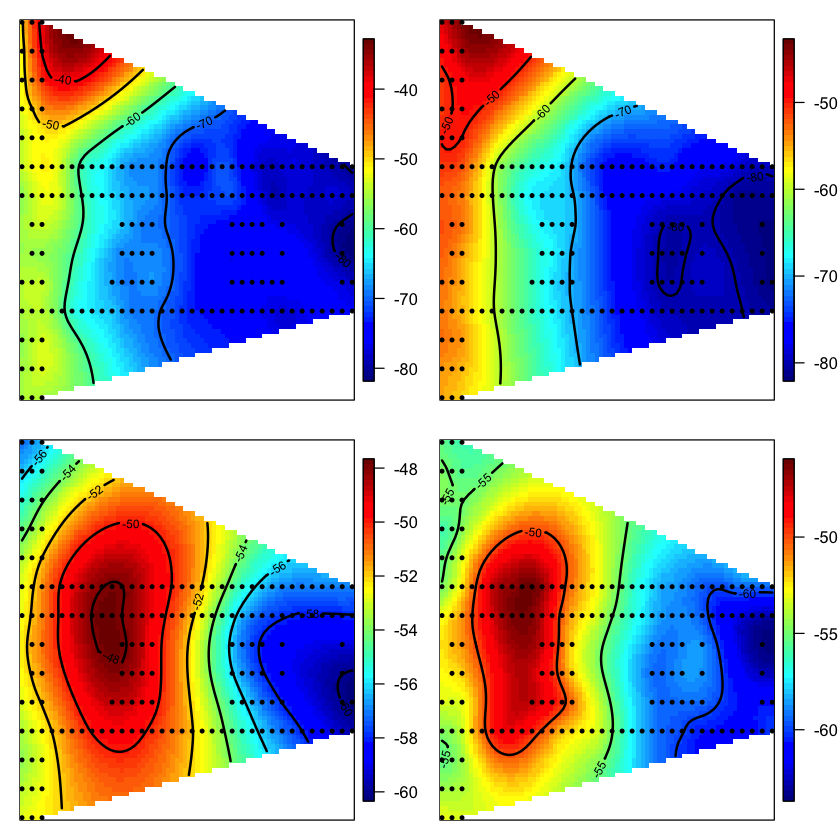

In [127]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)


*Table 24. Heatmap of the 4 MAC Address and Angle Excluding *

In [128]:
table(offlineSummary$mac)


00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
             1328              1328              1328              1328 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
             1328              1328              1328 

The output below shows the MAC addresses and thier corresponding coordinates.

In [129]:
#offlineSummary = subset(offlineSummary, mac != subMacs[3])

AP = matrix( c(7.5,6.3,7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3, 33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs, c("x", "y") ))
AP

x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:0f:a3:39:dd:cd  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

In [130]:
table(diffs)

                    posY
posX                 -14 -13 -12 -11 -10 -9.3 -9 -8.3 -8 -7.3 -7 -6.3 -6 -5.3
  -33.5                0   0   0   0   0    8  0    8  0    8  0    8  0    8
  -32.5                0   0   0   0   0    8  0    8  0    8  0    8  0    8
  -31.5                0   0   0   0   0    8  0    8  0    8  0    8  0    8
  -30.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -29.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -28.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -27.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -26.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -25.5                0   0   0   0   0    0  0    0  0    0  0    8  0    0
  -24.5                0   0   0   0   0    0  0    0  0    0  0    8  0    8
  -23.5                0   0   0   0   0    0  0    0  0    0  0    8  0    8
  -22.5                0   0   0   0   

The next block of code gives us a scatterplot of the relationship between the signal strength and the distance of each access point from the receiver.Notice that the shape is fairly consistent across all combinations.

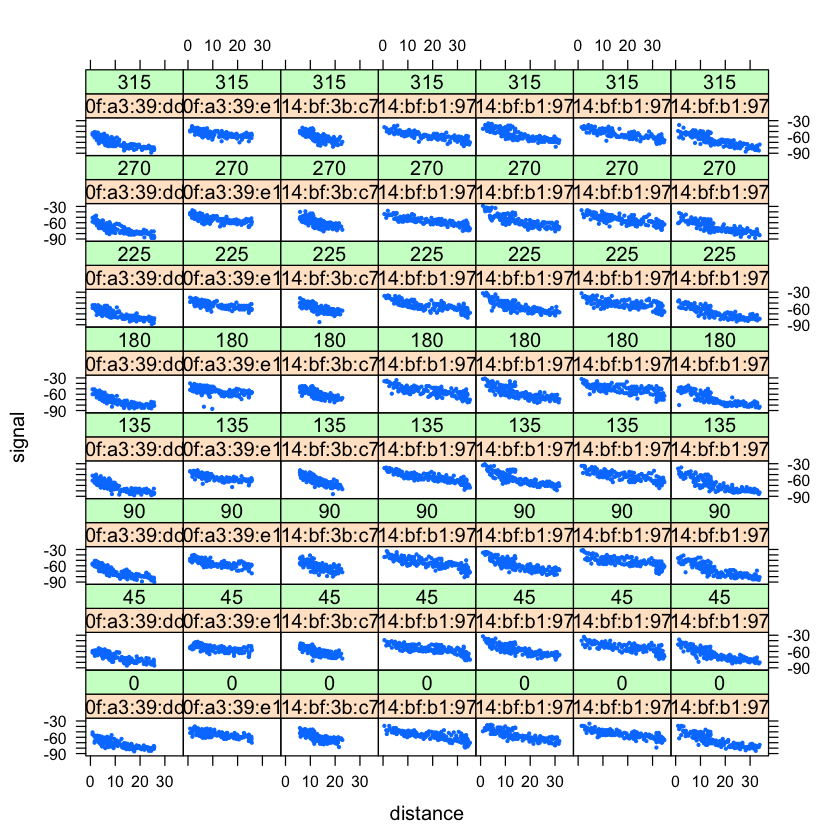

In [131]:
diffs = offlineSummary[ , c("posX", "posY")] - 
          AP[ offlineSummary$mac, ]

offlineSummary$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(signal ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary, pch = 19, cex = 0.3,
       xlab ="distance")


*Table 25. Signal Strength vs. Distance to Access Point Excluding 00:0f:a3:39:dd:cd.*

### K-Nearest Neighbors Approach (k-NN)

In [132]:
macs = unique(offlineSummary$mac)

In [133]:
table(macs)

macs
00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81 
                1                 1                 1                 1 
00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90 
                1                 1                 1 

In [134]:
online = readData("online.final.trace.txt", subMacs = macs)

In [135]:
online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

[1] 60

Here the data set is being reorganized into a different structure for ease of use.

In [136]:
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:7, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$signal, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 7,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

dim(onlineSummary)

            
               0  45  90 135 180 225 270 315
  0-0.05       0   0   0 704   0   0   0   0
  0.15-9.42    0   0 717   0   0   0   0   0
  0.31-11.09   0   0   0   0   0 684   0   0
  0.47-8.2   701   0   0   0   0   0   0   0
  0.78-10.94 695   0   0   0   0   0   0   0
  0.93-11.69   0   0   0   0 691   0   0   0
  1.08-12.19   0   0   0   0   0 742   0   0

[1] 60 12

Finding records in the offline data set that have similar orientations to the unknown observations.

In [137]:
names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:dd:cd"
 [7] "00:0f:a3:39:e1:c0" "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81"
[10] "00:14:bf:b1:97:8a" "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [138]:
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
      
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

In [139]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

In [140]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSubset, varSignal = "avgSignal")

In [141]:
selectTrain = function(angleNewObs, signals = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = signals[ signals$angle %in% angles, ]
  reshapeSS(offlineSubset, varSignal = "avgSignal")
}

In [142]:
train130 = selectTrain(130, offlineSummary, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:dd:cd 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6
0-0  0-0   0     0   -72               -52               -66              
0-1  0-1   0     1   -70               -53               -65              
0-10 0-10  0    10   -70               -56               -66              
0-11 0-11  0    11   -71               -55               -67              
0-12 0-12  0    12   -69               -56               -70              
0-13 0-13  0    13   -73               -55               -71              
     00:14:bf:b1:97:81 00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  -63               -36               -64               -55              
0-1  -64               -39               -65               -59              
0-10 -69               -45               -67               -50              
0-11 -70               -48               -67               -55              
0-12 -72               -45               -67               -50              
0-13 -73               -43               -69               -54

[1] 166

Now, we have the training data set complete and ready to use for location prediction. The findNN() function will calculate the distances from the new point to all the observations in the training data set.

In [143]:
findNN = function(newSignal, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newSignal)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [144]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newSignal = as.numeric(newSignals[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

Here we are testing the above functions.

In [145]:
estXYk3 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 3)

estXYk1 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 1)

In [146]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

In [147]:
trainPoints = offlineSummary[ offlineSummary$angle == 0,
                        c("posX", "posY")]


The plots below (Table 26 and 27) show the predicted and actual locations for 3 and 1 nearest neighbors.

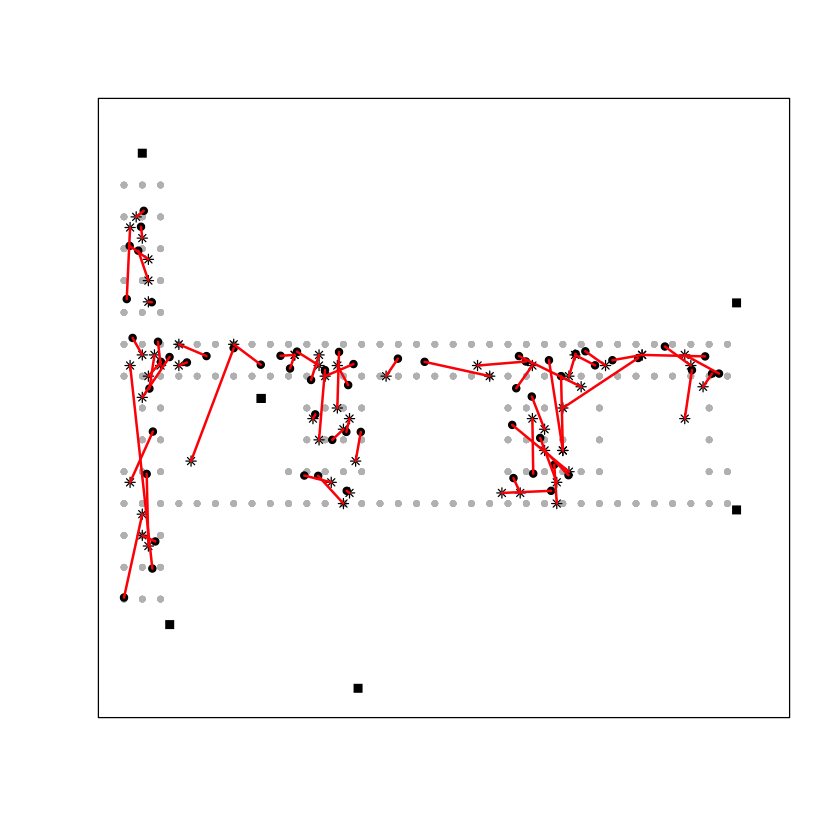

In [148]:
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


*Table 26. Floor Plan with Predicted and Actual Locations with 3 Nearest Neighbors.*

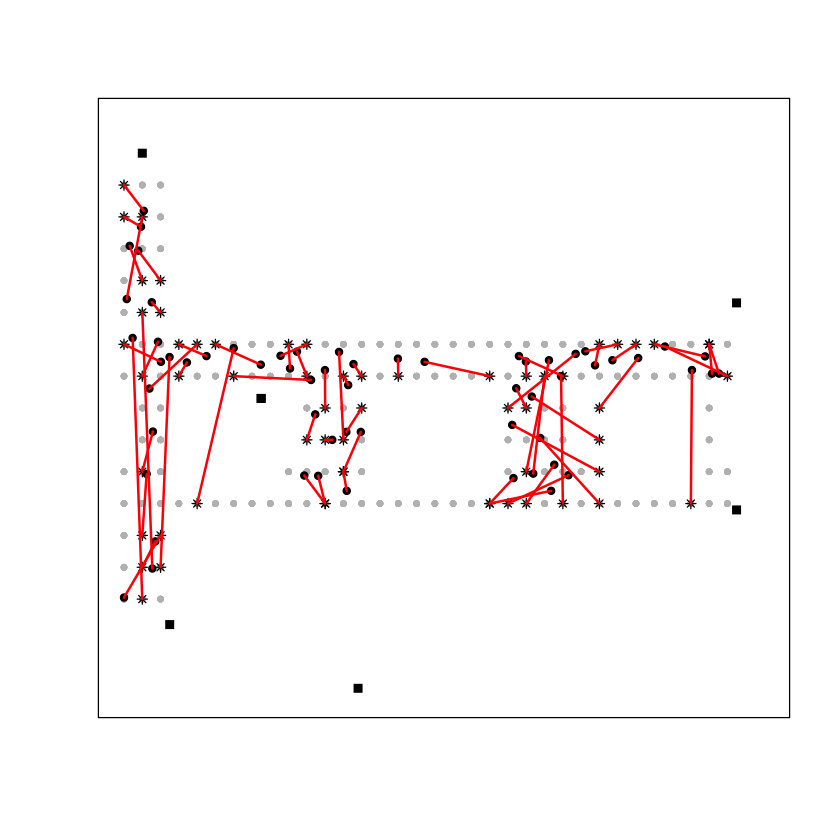

In [149]:
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)


*Table 27. Floor Plan with Predicted and Actual Locations with 1 Nearest Neighbors.*

In [150]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 510 244

The errors calculated above for k=1 and k=3 are approximately 510 and 244. This tells us that when k=3, we have a lower error and therefore, a better location prediction model.


In the next section we are developing the training and test data sets using v-fold cross-validation.

In [151]:
v = 11
permuteLocs = sample(unique(offlineSummary$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))
onlineFold = subset(offlineSummary, posXY %in% permuteLocs[ , 1])


Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

In [152]:
reshapeSS = function(data, varSignal = "signal", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varSignal ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 7,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [153]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline, keepVars = keepVars, 
                            sampleAngle = TRUE)

In [154]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newSignals = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 189

This created the first fold and ran an error calculation with an output around 100. Remember the folds are chosen at random so it unlikely we will get the same error twice.

Now we are going to loop through and create the number of folds specified by 'v'. We also specify the range of neighbors (0-20).

In [155]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newSignals = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

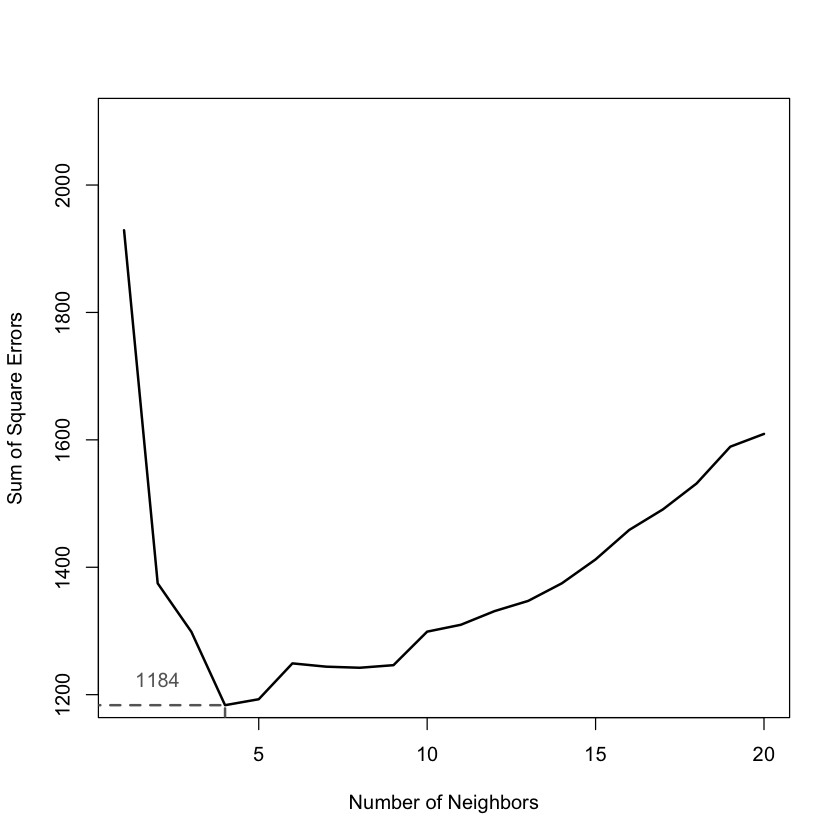

In [156]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

*Table 28. Sum of Square Errors vs. Number of Neighbors*

The above graph depicts the sum of squares error for each of the number of neighbors. Looking at the chart it is clear again that ten neighbors yield the best results. Going forward we will uses ten neighbors for comparing this dataset to the others.

In [157]:
estXYk5 = predXY(newSignals = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary, numAngles = 3, k = 10)

calcError(estXYk5, actualXY)

[1] 234

Error calcuation for ten neighbors.

In [158]:
predXY = function(newSignals, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newSignals))
  
  for (i in 1:nrow(newSignals)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newSignal = as.numeric(newSignals[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}


## Weighted Analysis

The readData function is similar to the function that we have in the earlier section. This analysis is similar to the analysis above, except that we will be using weights as our focus instead of signal strength.

In [159]:
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

To begin the Weighted Analysis, we are reading in the offline data text file and removing the comments in the data file. 

In [160]:
offline = readData()
head(offline)

time                posX posY orientation mac               signal rawTime
1 2006-02-11 01:31:58 0    0    0           00:14:bf:b1:97:8a -38    1.1e+12
2 2006-02-11 01:31:58 0    0    0           00:14:bf:b1:97:90 -56    1.1e+12
3 2006-02-11 01:31:58 0    0    0           00:0f:a3:39:e1:c0 -53    1.1e+12
4 2006-02-11 01:31:58 0    0    0           00:14:bf:b1:97:8d -65    1.1e+12
5 2006-02-11 01:31:58 0    0    0           00:14:bf:b1:97:81 -65    1.1e+12
6 2006-02-11 01:31:58 0    0    0           00:14:bf:3b:c7:c6 -66    1.1e+12
  angle
1 0    
2 0    
3 0    
4 0    
5 0    
6 0

In [161]:
# Help received from Parker
offline$inverse <- 1 / offline$signal
summary(offline$inverse)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.040  -0.019  -0.017  -0.017  -0.015  -0.010 

In [162]:
# Help received from Parker
offline$inverseSum <- sum(offline$inverse)
summary(offline$inverseSum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -15800  -15800  -15800  -15800  -15800  -15800 

In [163]:
# Help received from Parker
offline["weight"] <- NA
offline$weight <- offline$inverse / offline$inverseSum
summary(offline$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
6.5e-07 9.5e-07 1.1e-06 1.1e-06 1.2e-06 2.5e-06 

In [164]:
offline$posXY = paste(offline$posX, offline$posY, sep = "-")

Next, we are creating a list of data frames for every combination of (x, y) angle and access point. Then, we create a function to summarize weighted data by AP, location and angle.

In [165]:
byLocAngleAP = with(offline, 
                    by(offline, list(posXY, angle, mac), 
                       function(x) x))

In [166]:
offlineWeightSummary = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medWeight = median(oneLoc$weight)
           ans$avgWeight = mean(oneLoc$weight)
           ans$numWeight = length(oneLoc$weight)
           ans$sdWeight = sd(oneLoc$weight)
           ans$iqrWeight = IQR(oneLoc$weight)
           ans
         })

offlineSummary = do.call("rbind", offlineWeightSummary) 

Table 29 shows boxplots of the weights by position. Each panel is a different MAC address. Later in this weighted analysis, we will be excluding and including certain MAC addresses, but for now we will look at all seven. The analysis presented in Nolan and Lang only display six because their analysis is focus on excluding the MAC address ending in cd because it was determined that it adds no value. In the plots below, it seems like there is some variability within the plots. Some summary statistics for the weights are also given below. The mean is approximately 1.093e-06.

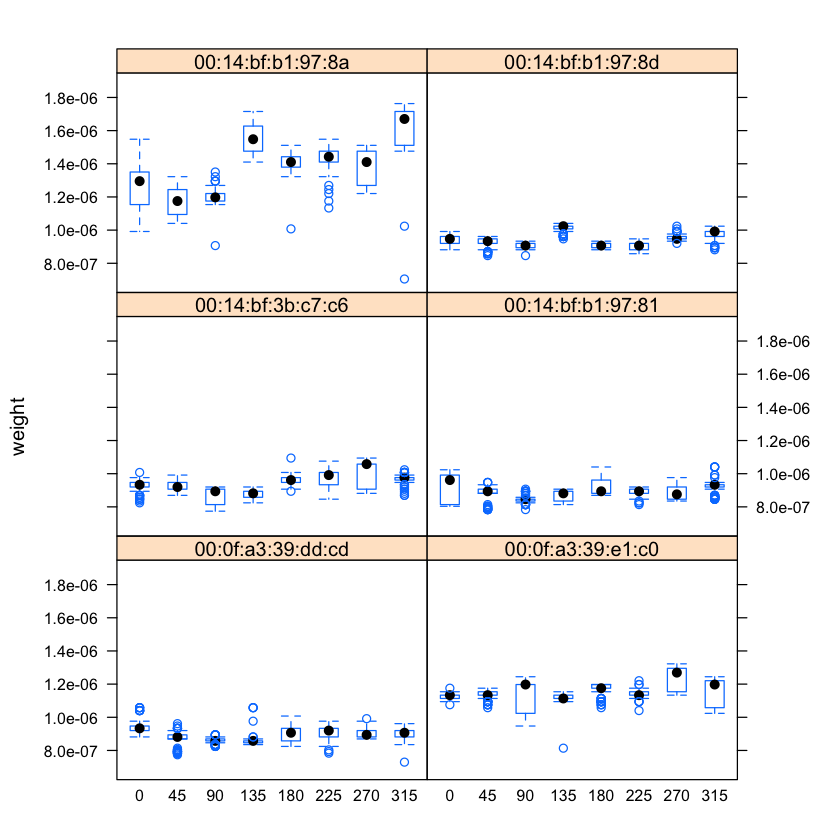

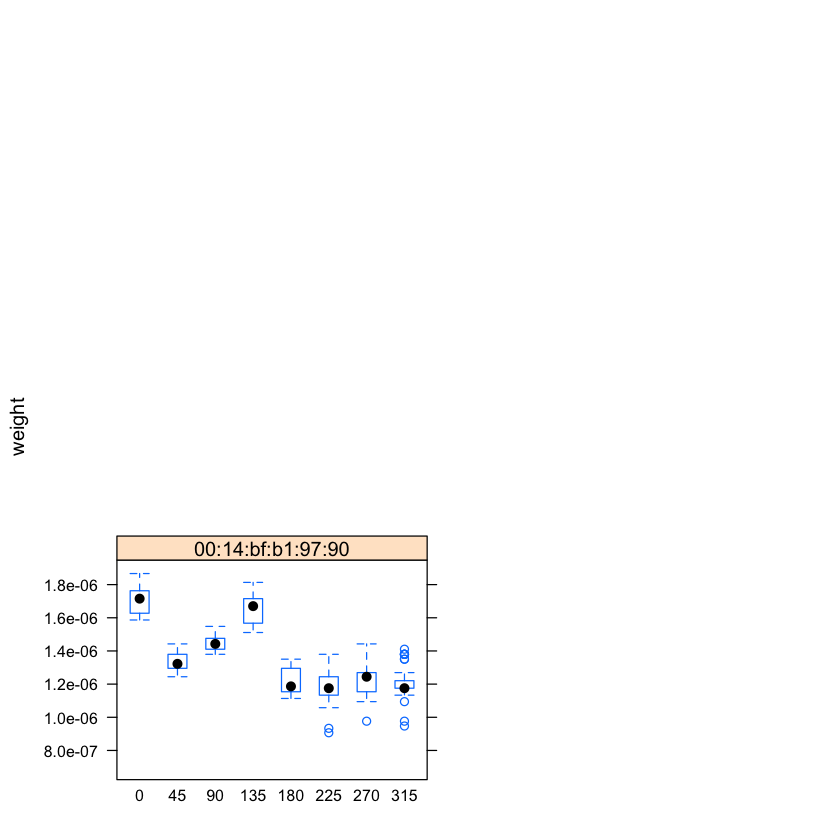

In [167]:
library(lattice)
bwplot(weight ~ factor(angle) | mac, data = offline, 
       subset = posX == 2 & posY == 12, 
       layout = c(2,3))

*Table 29. Weight by Angle for Each Access Point*

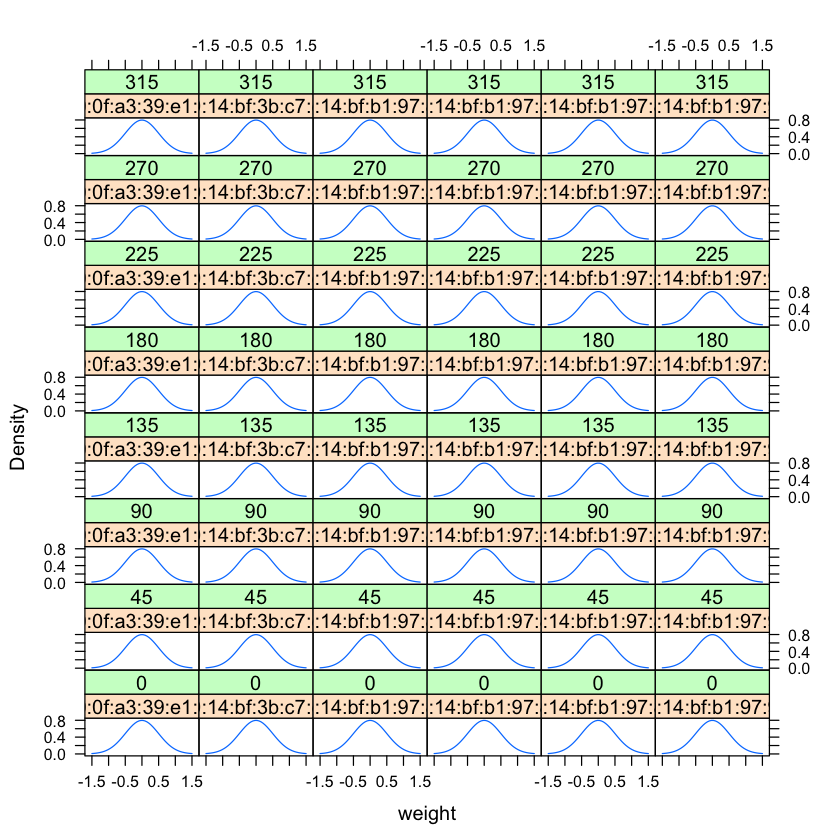

In [168]:
densityplot( ~ weight | mac + factor(angle), data = offline,
             subset = posX == 24 & posY == 4 & 
                         mac != "00:0f:a3:39:dd:cd",
             bw = 0.5, plot.points = FALSE)

*Table 30. Distribution of Weight by Angle for Each Access Point with no exclusions*

## Weighted Analysis excluding MAC address 00:0f:a3:39:dd:cd

Here, we are creating a data frame excluding the 00:0f:a3:39:dd:cd MAC address. posXY is a factor that contains all unique combinations of (x,y) pairs at 166 locations. Next, we are creating a list of data frames for every combination of (x, y) angle and access point. Then, we create a function to summarize signal data by AP, location and angle.

In [169]:
offline_cd = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
offline_cd$posXY = paste(offline_cd$posX, offline_cd$posY, sep = "-")

In [170]:
# Help received from Parker
offline_cd$inverse <- 1 / offline_cd$signal
summary(offline_cd$inverse)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.040  -0.020  -0.017  -0.018  -0.016  -0.011 

In [171]:
# Help received from Parker
offline_cd$inverseSum <- sum(offline_cd$inverse)
summary(offline_cd$inverseSum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -13700  -13700  -13700  -13700  -13700  -13700 

In [172]:
# Help received from Parker
offline_cd["weight"] <- NA
offline_cd$weight <- offline_cd$inverse / offline_cd$inverseSum
summary(offline$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
6.5e-07 9.5e-07 1.1e-06 1.1e-06 1.2e-06 2.5e-06 

In [173]:
byLocAngleAP = with(offline_cd, 
                    by(offline_cd, list(posXY, angle, mac), 
                       function(x) x))

In [174]:
offlineWeightSummary_cd = 
  lapply(byLocAngleAP,            
         function(oneLoc) {
           ans = oneLoc[1, ]
           ans$medWeight = median(oneLoc$weight)
           ans$avgWeight = mean(oneLoc$weight)
           ans$numWeight = length(oneLoc$weight)
           ans$sdWeight = sd(oneLoc$weight)
           ans$iqrWeight = IQR(oneLoc$weight)
           ans
         })

offlineSummary_cd = do.call("rbind", offlineWeightSummary_cd) 

In [ ]:
breaks = seq(-90, -30, by = 5)
bwplot(sdWeight ~ cut(avgWeight, breaks = breaks),
       data = offlineSummary_cd, 
       subset = mac != "00:0f:a3:39:dd:cd",
       xlab = "Mean Weight", ylab = "SD Weight")

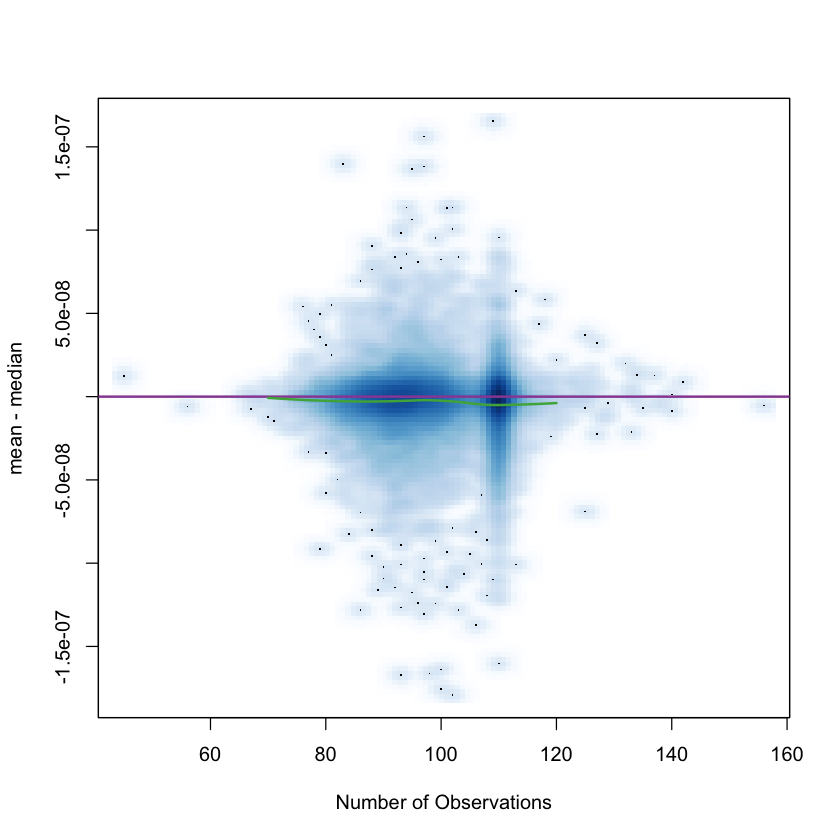

In [176]:
with(offlineSummary,
     smoothScatter((avgWeight - medWeight) ~ numWeight,
                   xlab = "Number of Observations", 
                   ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)

lo.obj = 
  with(offlineSummary,
       loess(diff ~ numWeight, 
             data = data.frame(diff = (avgWeight - medWeight),
                               numWeight = numWeight)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(numWeight = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)

*Table 31. Comparison of Mean and Median Weight excluding 00:0f:a3:39:dd:cd*

In [177]:
subMacs = names(sort(table(offline$mac), decreasing = TRUE))[1:7]

### Relationship Between Weight and Distance

In [178]:
oneAPAngle = subset(offline_cd, mac == subMacs[5] & angle == 0) 
oneAPAngle = subset(offlineSummary_cd, mac == subMacs[5] & angle == 0)

In [179]:
library(fields)
smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
               oneAPAngle$avgWeight)

[1] 6400    2


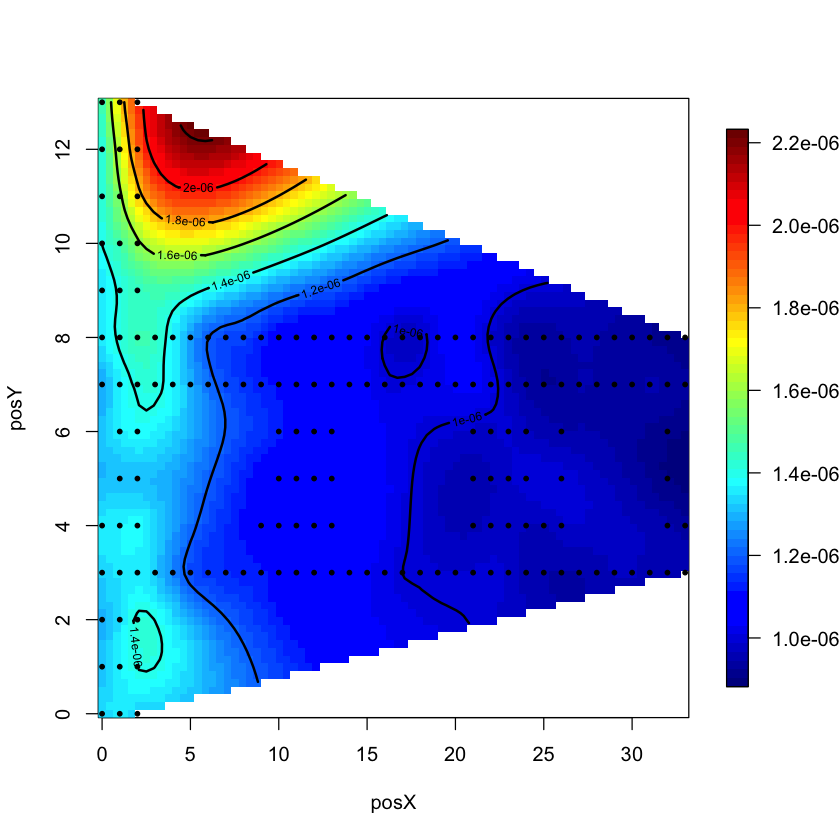

In [180]:
vizSmooth = predictSurface(smoothSS)

plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

*Table 32. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:dd:cd*

In [181]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgWeight)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

[1] 6400    2
[1] 6400    2
[1] 6400    2
[1] 6400    2


$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL


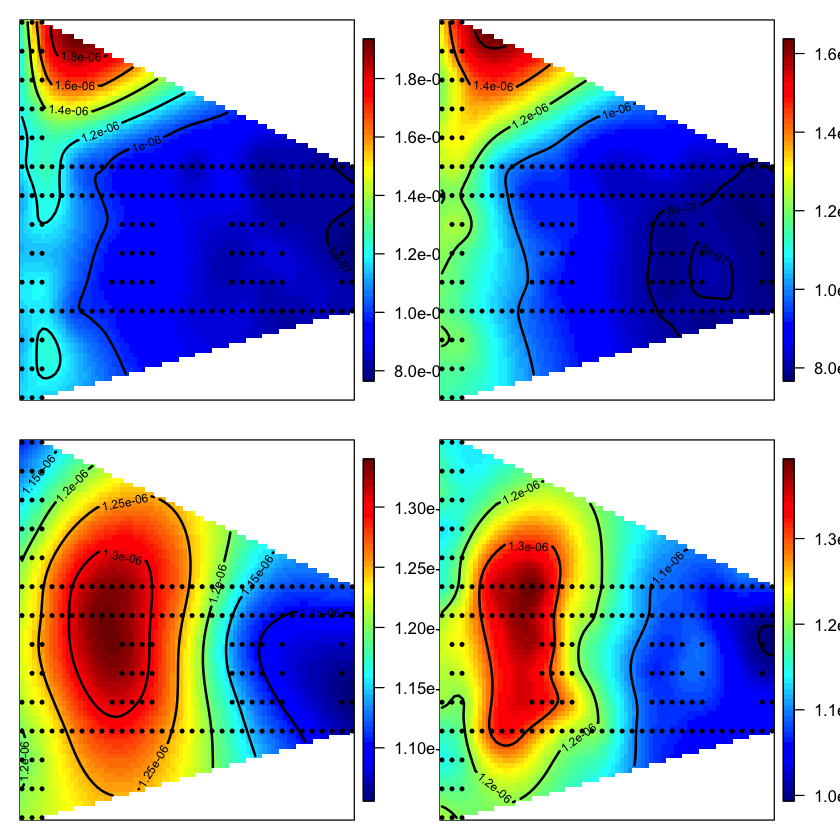

In [182]:
parCur = par(mfrow = c(2,2), mar = rep(1, 4))

mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ], 
       angle = rep(c(0, 135), 2),
       data = list(data = offlineSummary))
 
par(parCur)

*Table 33. Heatmap of the One MAC Address and Angle Excluding 00:0f:a3:39:dd:cd*

In [183]:
offlineSummary_cd = subset(offlineSummary_cd, mac != subMacs[2])

AP = matrix( c( 7.5, 6.3, 2.5, -.8, 12.8, -2.8,  
                1, 14, 33.5, 9.3,  33.5, 2.8),
            ncol = 2, byrow = TRUE,
            dimnames = list(subMacs[ -2 ], c("x", "y") ))

AP

x    y   
00:0f:a3:39:e1:c0  7.5  6.3
00:14:bf:b1:97:8a  2.5 -0.8
00:14:bf:3b:c7:c6 12.8 -2.8
00:14:bf:b1:97:90  1.0 14.0
00:14:bf:b1:97:8d 33.5  9.3
00:14:bf:b1:97:81 33.5  2.8

The next block of code gives us a scatterplot of the relationship between the weight and the distance of each access point from the receiver. The differences are computed and the Euclidean distance is calculated for each access plot. The resulting plot shows the relationship between weight and distance for each of the 48 combinations of AP and angle. Notice that the shape is fairly consistent across all combinations.

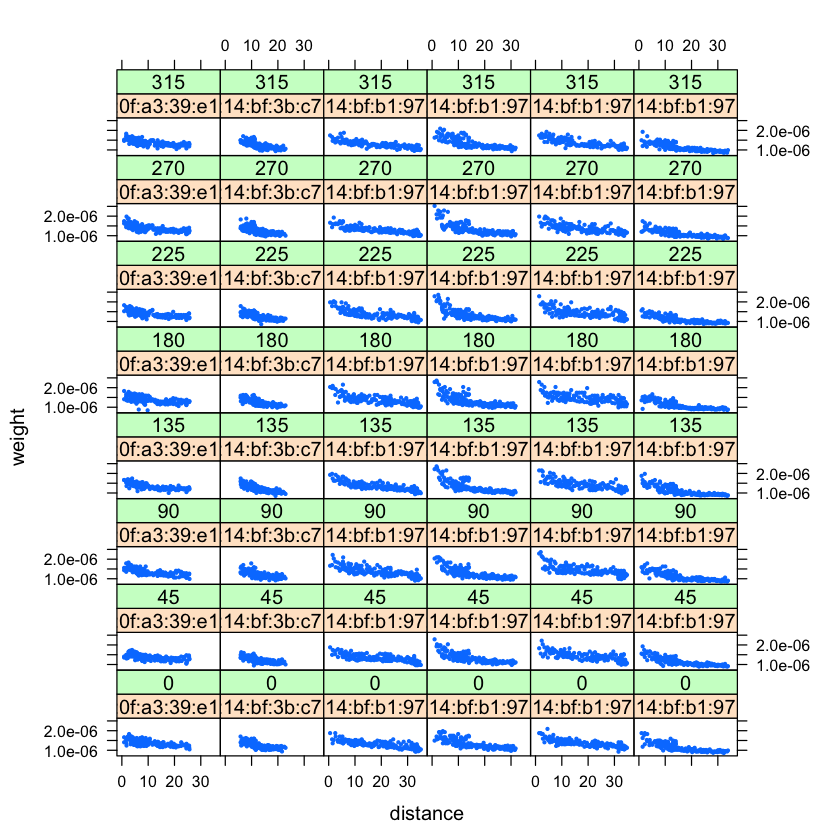

In [184]:
diffs = offlineSummary_cd[ , c("posX", "posY")] - 
          AP[ offlineSummary_cd$mac, ]

offlineSummary_cd$dist = sqrt(diffs[ , 1]^2 + diffs[ , 2]^2)

xyplot(weight ~ dist | factor(mac) + factor(angle), 
       data = offlineSummary_cd, pch = 19, cex = 0.3,
       xlab ="distance")

*Table 34. Signal Strength vs. Distance to Access Point Excluding 00:0f:a3:39:dd:cd.*

### K-Nearest Neighbors Approach (KNN)

In this next section, we will be using KNN to estimate the location of the device from the weight and the numerous access points we have. We will be using our training data set (offline) and finally bringing in the testing data set (online). The online data set contains the unknown locations. Our goal is to estimate the locations based on the training data. In the end, we will assess the accuracy of the predictions and determine which MAC address to include or exclude. Currently we are still excluding the 00:0f:a3:39:dd:cd MAC address. We have 60 unique test locations.

In [185]:
macs = unique(offlineSummary_cd$mac)

In [186]:
online = readData("online.final.trace.txt", subMacs = macs)

In [187]:
# Help received from Parker
online$inverse <- 1 / online$signal
summary(online$inverse)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -0.034  -0.019  -0.018  -0.018  -0.016  -0.011 

In [188]:
# Help received from Parker
online$inverseSum <- sum(online$inverse)
summary(online$inverseSum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   -616    -616    -616    -616    -616    -616 

In [189]:
# Help received from Parker
online["weight"] <- NA
online$weight <- online$inverse / online$inverseSum
summary(online$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
1.8e-05 2.5e-05 2.8e-05 2.9e-05 3.1e-05 5.6e-05 

In [190]:
online$posXY = paste(online$posX, online$posY, sep = "-")

length(unique(online$posXY))

[1] 60

The output below shows a summary of the number of weights recorded at each location. The summary shows us that the weights were recorded with one orientation for each location.

Next we are reorganizing the data set in a different structure for ease of use. The average weight at each location is given. We are keeping only the useful variables in the data set. 

In [191]:
tabonlineXYA = table(online$posXY, online$angle)
tabonlineXYA[1:6, ]

keepVars = c("posXY", "posX","posY", "orientation", "angle")
byLoc = with(online, 
             by(online, list(posXY), 
                function(x) {
                  ans = x[1, keepVars]
                  avgSS = tapply(x$weight, x$mac, mean)
                  y = matrix(avgSS, nrow = 1, ncol = 6,
                        dimnames = list(ans$posXY, names(avgSS)))
                  cbind(ans, y)
                }))

onlineSummary = do.call("rbind", byLoc)  

dim(onlineSummary)

0   45 90  135 180 225 270 315
  0-0.05       0 0    0 593   0   0 0   0  
  0.15-9.42    0 0  606   0   0   0 0   0  
  0.31-11.09   0 0    0   0   0 573 0   0  
  0.47-8.2   590 0    0   0   0   0 0   0  
  0.78-10.94 586 0    0   0   0   0 0   0  
  0.93-11.69   0 0    0   0 583   0 0   0

[1] 60 11

Next, our goal is to find records in the offline data set that have similar orientations to the unknown observations because it can impact the weight. In order to accomplish this, we found records with an orientation that is in a specific range of the unknown observation's orientation. Here, m is the number of angles to keep between 1 and 5. It is used to create the subset of the angles we desire.

In [192]:
names(onlineSummary)
m = 3; angleNewObs = 230
refs = seq(0, by = 45, length  = 8)
nearestAngle = roundOrientation(angleNewObs)

[1] "posXY"             "posX"              "posY"             
 [4] "orientation"       "angle"             "00:0f:a3:39:e1:c0"
 [7] "00:14:bf:3b:c7:c6" "00:14:bf:b1:97:81" "00:14:bf:b1:97:8a"
[10] "00:14:bf:b1:97:8d" "00:14:bf:b1:97:90"

In [193]:
if (m %% 2 == 1) {
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
} else {
  m = m + 1
  angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  if (sign(angleNewObs - nearestAngle) > -1) 
    angles = angles[ -1 ]
  else 
    angles = angles[ -m ]
}
      
angles = angles + nearestAngle
angles[angles < 0] = angles[ angles < 0 ] + 360
angles[angles > 360] = angles[ angles > 360 ] - 360

In [194]:
offlineSubset = 
  offlineSummary[ offlineSummary$angle %in% angles, ]

In [197]:
reshapeSS = function(data, varWeight = "weight", 
                     keepVars = c("posXY", "posX","posY")) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varWeight ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

trainSS = reshapeSS(offlineSummary_cd, varWeight = "avgWeight")

In [198]:
selectTrain = function(angleNewObs, weights = NULL, m = 1){
  # m is the number of angles to keep between 1 and 5
  refs = seq(0, by = 45, length  = 8)
  nearestAngle = roundOrientation(angleNewObs)
  
  if (m %% 2 == 1) 
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
  else {
    m = m + 1
    angles = seq(-45 * (m - 1) /2, 45 * (m - 1) /2, length = m)
    if (sign(angleNewObs - nearestAngle) > -1) 
      angles = angles[ -1 ]
    else 
      angles = angles[ -m ]
  }
  angles = angles + nearestAngle
  angles[angles < 0] = angles[ angles < 0 ] + 360
  angles[angles > 360] = angles[ angles > 360 ] - 360
  angles = sort(angles) 
  
  offlineSubset = weights[ weights$angle %in% angles, ]
  reshapeSS(offlineSubset, varWeight = "avgWeight")
}

In [199]:
train130 = selectTrain(130, offlineSummary_cd, m = 3)

head(train130)

length(train130[[1]])

posXY posX posY 00:0f:a3:39:e1:c0 00:14:bf:3b:c7:c6 00:14:bf:b1:97:81
0-0  0-0   0     0   1.4e-06           1.1e-06           1.2e-06          
0-1  0-1   0     1   1.4e-06           1.1e-06           1.2e-06          
0-10 0-10  0    10   1.3e-06           1.1e-06           1.1e-06          
0-11 0-11  0    11   1.3e-06           1.1e-06           1.0e-06          
0-12 0-12  0    12   1.3e-06           1.0e-06           1.0e-06          
0-13 0-13  0    13   1.3e-06           1.0e-06           1.0e-06          
     00:14:bf:b1:97:8a 00:14:bf:b1:97:8d 00:14:bf:b1:97:90
0-0  2.1e-06           1.1e-06           1.3e-06          
0-1  1.9e-06           1.1e-06           1.2e-06          
0-10 1.6e-06           1.1e-06           1.5e-06          
0-11 1.5e-06           1.1e-06           1.3e-06          
0-12 1.6e-06           1.1e-06           1.5e-06          
0-13 1.7e-06           1.1e-06           1.4e-06

[1] 166

Now, we have the training data set complete and ready to use for location prediction. The findNN() function will calculate the distances from the new point to all the observations in the training data set. 

In [200]:
findNN = function(newWeight, trainSubset) {
  diffs = apply(trainSubset[ , 4:9], 1, 
                function(x) x - newWeight)
  dists = apply(diffs, 2, function(x) sqrt(sum(x^2)) )
  closest = order(dists)
  return(trainSubset[closest, 1:3 ])
}

In [201]:
predXY = function(newWeights, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newWeights))
  
  for (i in 1:nrow(newWeights)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = 
      findNN(newWeight = as.numeric(newWeights[i, ]), trainSS)
  }

  estXY = lapply(closeXY, 
                 function(x) sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

Here, we are testing the above functions with 3 nearest neighbors and 3 orientations along with 1 nearest neighbor.

In [203]:
estXYk3 = predXY(newWeights = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 3)

estXYk1 = predXY(newWeights = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 1)

In [204]:
floorErrorMap = function(estXY, actualXY, trainPoints = NULL, AP = NULL){
  
    plot(0, 0, xlim = c(0, 35), ylim = c(-3, 15), type = "n",
         xlab = "", ylab = "", axes = FALSE)
    box()
    if ( !is.null(AP) ) points(AP, pch = 15)
    if ( !is.null(trainPoints) )
      points(trainPoints, pch = 19, col="grey", cex = 0.6)
    
    points(x = actualXY[, 1], y = actualXY[, 2], 
           pch = 19, cex = 0.8 )
    points(x = estXY[, 1], y = estXY[, 2], 
           pch = 8, cex = 0.8 )
    segments(x0 = estXY[, 1], y0 = estXY[, 2],
             x1 = actualXY[, 1], y1 = actualXY[ , 2],
             lwd = 2, col = "red")
}

In [205]:
trainPoints = offlineSummary_cd[ offlineSummary_cd$angle == 0 & 
                              offlineSummary_cd$mac == "00:0f:a3:39:e1:c0" ,
                        c("posX", "posY")]

The plots below (Table 36 and 37) show the predicted and actual locations for 3 and 1 nearest neighbors. The red lines connect the test locations to the predicted locations. Just by looking at the plot, we can see that when k = 3, the predictions seem to be better.

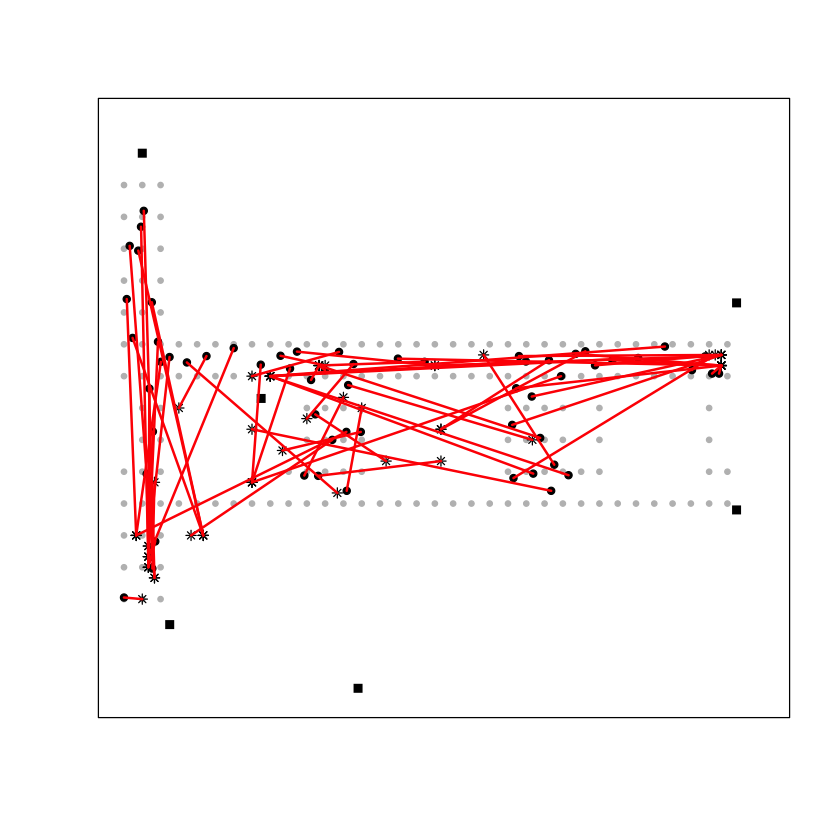

In [207]:
floorErrorMap(estXYk3, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 35. Floor Plan with Predicted and Actual Locations with 3 Nearest Neighbors.*

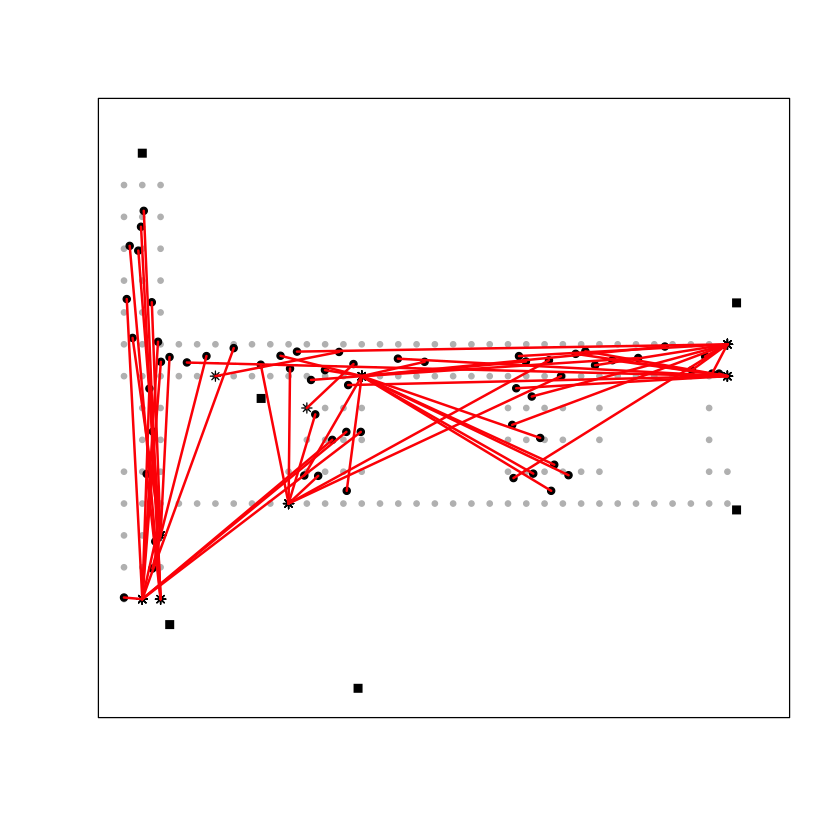

In [208]:
floorErrorMap(estXYk1, onlineSummary[ , c("posX","posY")], 
              trainPoints = trainPoints, AP = AP)

*Table 36. Floor Plan with Predicted and Actual Locations with 1 Nearest Neighbor.*

In [209]:
calcError = 
function(estXY, actualXY) 
   sum( rowSums( (estXY - actualXY)^2) )

actualXY = onlineSummary[ , c("posX", "posY")]
sapply(list(estXYk1, estXYk3), calcError, actualXY)

[1] 6406 5248

The errors calculated above for k=1 and k=3 are approximately 6405 and 5248. This tells us that when k=3, we have a lower error and therefore, a better location prediction model.

In [210]:
v = 11
permuteLocs = sample(unique(offlineSummary_cd$posXY))
permuteLocs = matrix(permuteLocs, ncol = v, 
                     nrow = floor(length(permuteLocs)/v))
onlineFold = subset(offlineSummary_cd, posXY %in% permuteLocs[ , 1])

Warning message in matrix(permuteLocs, ncol = v, nrow = floor(length(permuteLocs)/v)):
“data length [166] is not a sub-multiple or multiple of the number of rows [15]”

In [211]:
reshapeSS = function(data, varWeight = "weight", 
                     keepVars = c("posXY", "posX","posY"),
                     sampleAngle = FALSE, 
                     refs = seq(0, 315, by = 45)) {
  byLocation =
    with(data, by(data, list(posXY), 
                  function(x) {
                    if (sampleAngle) {
                      x = x[x$angle == sample(refs, size = 1), ]}
                    ans = x[1, keepVars]
                    avgSS = tapply(x[ , varWeight ], x$mac, mean)
                    y = matrix(avgSS, nrow = 1, ncol = 6,
                               dimnames = list(ans$posXY,
                                               names(avgSS)))
                    cbind(ans, y)
                  }))

  newDataSS = do.call("rbind", byLocation)
  return(newDataSS)
}

In [212]:
#offline = offline[ offline$mac != "00:0f:a3:39:dd:cd", ]
keepVars = c("posXY", "posX","posY", "orientation", "angle")

onlineCVSummary = reshapeSS(offline_cd, keepVars = keepVars, 
                            sampleAngle = TRUE)

In [213]:
onlineFold = subset(onlineCVSummary, 
                    posXY %in% permuteLocs[ , 1])

offlineFold = subset(offlineSummary_cd,
                     posXY %in% permuteLocs[ , -1])

estFold = predXY(newWeights = onlineFold[ , 6:11], 
                 newAngles = onlineFold[ , 4], 
                 offlineFold, numAngles = 3, k = 3)

actualFold = onlineFold[ , c("posX", "posY")]
calcError(estFold, actualFold)

[1] 235

In [215]:
K = 20
err = rep(0, K)

for (j in 1:v) {
  onlineFold = subset(onlineCVSummary, 
                      posXY %in% permuteLocs[ , j])
  offlineFold = subset(offlineSummary_cd,
                       posXY %in% permuteLocs[ , -j])
  actualFold = onlineFold[ , c("posX", "posY")]
  
  for (k in 1:K) {
    estFold = predXY(newWeights = onlineFold[ , 6:11],
                     newAngles = onlineFold[ , 4], 
                     offlineFold, numAngles = 3, k = k)
    err[k] = err[k] + calcError(estFold, actualFold)
  }
}

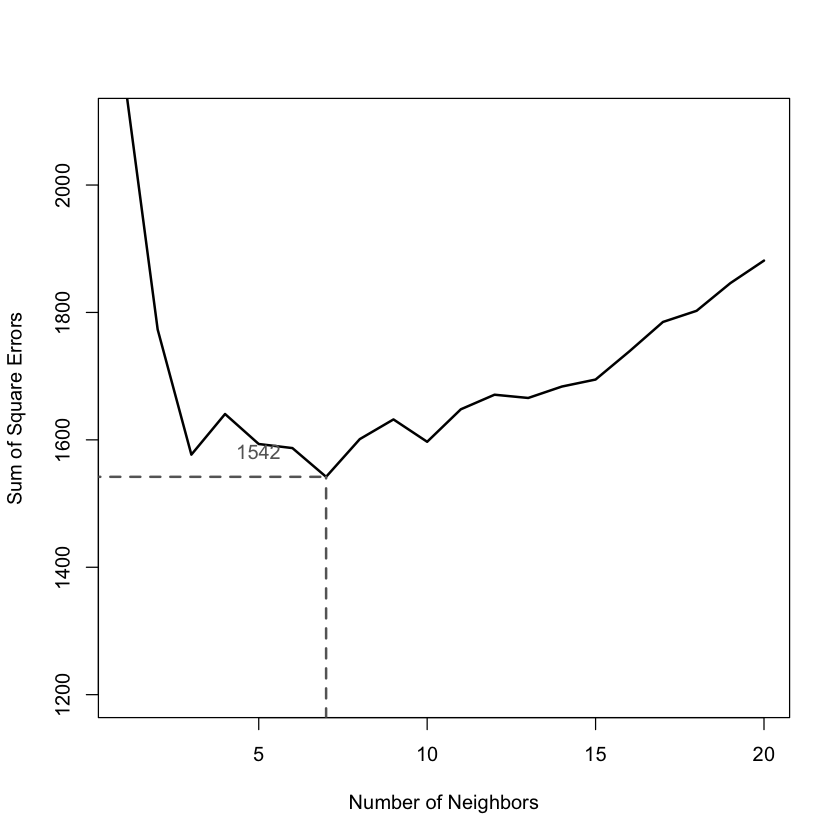

In [216]:
plot(y = err, x = (1:K),  type = "l", lwd= 2,
     ylim = c(1200, 2100),
     xlab = "Number of Neighbors",
     ylab = "Sum of Square Errors")

rmseMin = min(err)
kMin = which(err == rmseMin)[1]
segments(x0 = 0, x1 = kMin, y0 = rmseMin, col = gray(0.4), 
         lty = 2, lwd = 2)
segments(x0 = kMin, x1 = kMin, y0 = 1100,  y1 = rmseMin, 
         col = grey(0.4), lty = 2, lwd = 2)

#mtext(kMin, side = 1, line = 1, at = kMin, col = grey(0.4))
text(x = kMin - 2, y = rmseMin + 40, 
     label = as.character(round(rmseMin)), col = grey(0.4))

*Table 37. Sum of Square Errors vs. Number of Neighbors*

In [217]:
estXYk5 = predXY(newWeights = onlineSummary[ , 6:11], 
                 newAngles = onlineSummary[ , 4], 
                 offlineSummary_cd, numAngles = 3, k = 5)

calcError(estXYk5, actualXY)

[1] 3380

In [ ]:
predXY = function(newWeights, newAngles, trainData, 
                  numAngles = 1, k = 3){
  
  closeXY = list(length = nrow(newWeights))
  
  for (i in 1:nrow(newWeights)) {
    trainSS = selectTrain(newAngles[i], trainData, m = numAngles)
    closeXY[[i]] = findNN(newWeight = as.numeric(newWeights[i, ]),
                           trainSS)
  }

  estXY = lapply(closeXY, function(x)
                            sapply(x[ , 2:3], 
                                    function(x) mean(x[1:k])))
  estXY = do.call("rbind", estXY)
  return(estXY)
}

# CONCLUSION

The focus of our analysis was to explore Indoor positioning systems (IPS) Building an indoor positioning system required training and testing data. We used the offline data set for the training data and the online data set for the testing data. We then built a model to predict the unknown locations of the scanning devices in the online data set. We then used k-Nearest Neighbors to determine which model is the most efficient.

The researchers decided to keep the access point with MAC address 00:0f:a3:39:e1:c0 and remove 00:0f:a3:39:dd:cd, along with its corresponding data. In our analysis, we decided to exclude 00:0f:a3:39:dd:cd, then see the difference in our model by excluding 00:0f:a3:39:e1:c0. When we excluded 00:0f:a3:39:dd:cd, our lowest error rate using k-Nearest Neighbors was 425. In this case k=8 was optimal. When we excluded 00:0f:a3:39:e1:c0, our lowest error rate using k-Nearest Neighbors was 250. In this case k=5 was optimal. When we did not exclude any MAC addresses, our lowest error rate using k-Nearest Neighbors was 234. In this case k=10 was optimal. Looking at the error rates, we can see that using both MAC addresses might be beneficial. Using the v-fold cross-validation, excluding 00:0f:a3:39:e1:c0 has the lowest error. It's interesting to note that the errors for 00:0f:a3:39:dd:cd are much higher than the other two cases. 

This approach have yielded almost a pair of individual test points and predicted points and aggregated all distances between them and errors is closer to the true distance. See summary below:

    CALC  ERROR Summary
                                         kNN
                        k=1	    k=3      k=5	  k=8       k=10
    Excluding 1 MAC :cd 579.08	482.54   -----    425.11	----- 
    Excluding 1 MAC :c0 411.64	270.45   249.92   -----     -----
    All MACs included   510.40	244.20   -----    -----     233.97


The second approach we explored uses weights on the received signal strength. The weight is inversely proportional to the distance (signal strength) from the test observation. This allows for the predicted points that are closer to the access point to have a greater weight on the k-Nearest Neighbor calculation of location than the points that have a weaker signal strength. 

However, using the same set of algorithms with the weights value as parameter input, the weights have yielded fewer than 10 asterisks as the predicted points. When algorithm calculates vectors from test points (black dots) to the predicted points (asterisks), estimated distances calculated have a relatively higher values because of the low predicted points. When all the estimated distances are aggregated from the test dataset, the resulting difference from the actual/true sum of distances calculated in the beginning to the new estimated distance using weights are much larger compared to the one using simple kNN approach. Regardless of the number of predicted points produced, data still shows that at k=5 still represents a lower error overall. See table below:

                                Weighted
                        k=1     k=3     k=5
                        6405.5  5248.07 3379.63

As a result, as AP signal strength decreases and tends to approach zero as distance becomes farther and having an area this size where devices are close to individual access point we were able to calculate and predict more realistically closer to actual distance between AP and devices using the simple approach of kNN signal and distance variables instead of the weights. Simple kNN approach also predicted more points relative to each individual test points, therefore, more accurate in predicting device location.


# REFERENCES

1. Data Science in R: A Case Studies Approach to Computational Reasoning and Problem Solving. (2015). S.l.: Apple Academic Press Inc.